# Visualization

### Martinez et al

In [ ]:
import pandas as pd
import numpy as np
import re


def preprocess_df(df, substrate_name):
    df.loc[df["Entry"] == "A0A0G2YL08", "Name"] = "EH124"
    df.loc[df["Entry"] == "A0A0S1LLE3", "Name"] = "EH138"
    df.loc[df["Entry"] == "A0A2H4ULE2", "Name"] = "EH101"
    df.loc[df["Entry"] == "A0A0G3FH10", "Name"] = "EH144"
    df.loc[df["Entry"] == "A0A0G3FH07", "Name"] = "EH134"
    df.loc[df["Entry"] == "A0A0G3FEQ8", "Name"] = "EH126"
    df.loc[df["Entry"] == "K0C4G5", "Name"] = "EH98"
    df.loc[df["Entry"] == "T1BE47", "Name"] = "EH45"
    df.loc[df["Entry"] == "K7QE48", "Name"] = "EH80"
    df.loc[df["Entry"] == "Q0VTL7", "Name"] = "EH8"
    df.loc[df["Entry"] == "A0A2H4UKY1", "Name"] = "EH70"
    df.loc[df["Entry"] == "A0A2H4ULC5", "Name"] = "EH74"
    df.loc[df["Entry"] == "A0A0G3FET6", "Name"] = "EH71"
    df.loc[df["Entry"] == "A0A2H4ULE0", "Name"] = "EH49"
    df.loc[df["Entry"] == "A0A0G3FJ44", "Name"] = "EH145"
    df.loc[df["Entry"] == "A0A2K8JN17", "Name"] = "EH66"
    df.loc[df["Entry"] == "Q0VLK5", "Name"] = "EH125"
    df.loc[df["Entry"] == "A0A2H4UKX9", "Name"] = "EH53"
    df.loc[df["Entry"] == "A0A2K8JT94", "Name"] = "EH2"
    df.loc[df["Entry"] == "A0A2K8JN75", "Name"] = "EH3"

    df['dist_ligand_closest_nuc'] = df['distance_ligand_to_closest_nuc'].apply(
    lambda d: list(d.values())[0] if isinstance(d, dict) and d else np.nan)

    df['dist_ligand_closest_squidly'] = df['distance_ligand_to_squidly_residues'].apply(
        lambda d: min(d.values()) if isinstance(d, dict) and d else np.nan)
    
    nucleophilic_residues = {'SER', 'CYS'}

    def get_min_dist_to_nucleophile(d):
        if not isinstance(d, dict) or not d:
            return np.nan
        return min(
            [dist for res, dist in d.items() if res.split('_')[0] in nucleophilic_residues],
            default=np.nan
        )
    df['dist_ligand_closest_squidly_nucleophile'] = df['distance_ligand_to_squidly_residues'].apply(get_min_dist_to_nucleophile)
    
    df['Substrate'] = substrate_name

    return df

df1 = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/B_benchmark_martinez/martinez_output_vinyl_oleate/geometricfiltering/plip_interactions.pkl')
df_dockmetrics = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/B_benchmark_martinez/martinez_output_n_pentyl_benzoate/geometricfiltering/plip_interactions.pkl')
df3 = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/B_benchmark_martinez/martinez_output_ethyl_butyrate/geometricfiltering/plip_interactions.pkl')
df4 = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/B_benchmark_martinez/martinez_output_glyceryl_triacetate/geometricfiltering/plip_interactions.pkl')
df5 = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/B_benchmark_martinez/martinez_output_1_napthyl_acetate/geometricfiltering/plip_interactions.pkl')

preprocess_df(df1, 'Vinyl oleate')
preprocess_df(df_dockmetrics, 'n-Pentyl benzoate')
preprocess_df(df3, 'Ethyl butyrate')
preprocess_df(df4, 'Glyceryl triacetate')
preprocess_df(df5, '1-Napthyl acetate')

df = pd.concat([df1, df_dockmetrics, df3, df4], axis = 0)


martinez = pd.read_csv('/nvme2/helen/masterthesis/1_manuscript/data/SI_Martinez_et_al_S3.csv', sep=';', encoding='ISO-8859-1') 

def assign_activity_by_substrate(df, martinez_df):
    # Clean Martinez column names
    martinez_df.columns = [re.sub(r"\(.*?\)", "", col).strip() for col in martinez_df.columns]
    
    df = df.copy()
    all_active_enzymes = {}

    # Process each substrate individually
    for substrate in df['Substrate'].unique():
        df_sub = df[df['Substrate'] == substrate]
        enzymes_in_df = df_sub['Name'].unique()
        martinez_sub = martinez_df[martinez_df['Substrate'] == substrate]

        if martinez_sub.empty:
            print(f"⚠️  No Martinez data found for substrate '{substrate}'")
            continue

        available_enzymes = [col for col in martinez_sub.columns if col in enzymes_in_df]
        active_enzymes = [
            enzyme for enzyme in available_enzymes
            if martinez_sub[enzyme].fillna(0).iloc[0] > 0
        ]

        print(f"✅ Active enzymes in df for {substrate}: {active_enzymes}")
        all_active_enzymes[substrate] = set(active_enzymes)

    # Assign activity
    def is_active(row):
        substrate = row['Substrate']
        enzyme = row['Name']
        return int(enzyme in all_active_enzymes.get(substrate, set()))

    df['activity'] = df.apply(is_active, axis=1)
    return df


df = assign_activity_by_substrate(df, martinez)
df = df.reset_index(drop=True)


features = ['fpocket_Pocket_Score', 'fpocket_Drug_Score',
       'fpocket_Num_alpha_spheres', 'fpocket_Mean_alpha_sphere_radius',
       'fpocket_Mean_alpha_sphere_Solvent_Acc',
       'fpocket_Hydrophobicity_Score', 'fpocket_Polarity_Score',
       'fpocket_Amino_Acid_based_volume_Score',
       'fpocket_Pocket_volume_Monte_Carlo',
       'fpocket_Pocket_volume_convex_hull', 'fpocket_Charge_Score',
       'fpocket_Local_hydrophobic_density_Score',
       'fpocket_Num_apolar_alpha_sphere',
       'fpocket_Proportion_apolar_alpha_sphere', 'total_sasa', 'polar_sasa',
       'apolar_sasa', 'sasa_ligand_in_complex', 'sasa_ligand_alone',
       'buried_sasa', 'percentage_buried_sasa', 
       'dist_ligand_closest_nuc', 'dist_ligand_closest_squidly', 'dist_ligand_closest_squidly_nucleophile', 
       'plip_hydrogen_nbonds',
       'plip_hydrophobic_contacts', 'plip_salt_bridges', 'plip_pi_stacking',
       'plip_pi_cation', 'plip_halogen_bonds', 'plip_water_bridges',
       'plip_metal_complexes', 'activity']

✅ Active enzymes in df for Vinyl oleate: []
✅ Active enzymes in df for n-Pentyl benzoate: ['EH2', 'EH3', 'EH8']
✅ Active enzymes in df for Ethyl butyrate: ['EH2', 'EH3', 'EH8']
✅ Active enzymes in df for Glyceryl triacetate: ['EH2', 'EH3', 'EH8', 'EH45', 'EH49', 'EH53', 'EH66', 'EH70', 'EH71', 'EH74', 'EH80', 'EH101']


### Exp tested

In [78]:
df_TPP = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_TPP/geometricfiltering/plip_interactions.pkl')
df_DEHP = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_DEHP/geometricfiltering/plip_interactions.pkl')

preprocess_df(df_TPP, 'TPP')
df_TPP['activity'] = df_TPP['Entry'].apply(lambda x: 1 if x in ['QHH21706', 'SbPTE', 'Q06174'] else 0)
preprocess_df(df_DEHP, 'DEHP')
df_DEHP['activity'] = df_DEHP['Entry'].apply(lambda x: 1 if x in ['QHH21706', 'SbPTE'] else 0)

df = pd.concat([df_TPP, df_DEHP], axis = 0)
df = df.reset_index(drop=True)

features = ['fpocket_Pocket_Score', 'fpocket_Drug_Score',
       'fpocket_Num_alpha_spheres', 'fpocket_Mean_alpha_sphere_radius',
       'fpocket_Mean_alpha_sphere_Solvent_Acc',
       'fpocket_Hydrophobicity_Score', 'fpocket_Polarity_Score',
       'fpocket_Amino_Acid_based_volume_Score',
       'fpocket_Pocket_volume_Monte_Carlo',
       'fpocket_Pocket_volume_convex_hull', 'fpocket_Charge_Score',
       'fpocket_Local_hydrophobic_density_Score',
       'fpocket_Num_apolar_alpha_sphere',
       'fpocket_Proportion_apolar_alpha_sphere', 'total_sasa', 'polar_sasa',
       'apolar_sasa', 'sasa_ligand_in_complex', 'sasa_ligand_alone',
       'buried_sasa', 'percentage_buried_sasa', 
       'dist_ligand_closest_nuc', 'dist_ligand_closest_squidly', 'dist_ligand_closest_squidly_nucleophile', 
       'plip_hydrogen_nbonds',
       'plip_hydrophobic_contacts', 'plip_salt_bridges', 'plip_pi_stacking',
       'plip_pi_cation', 'plip_halogen_bonds', 'plip_water_bridges',
       'plip_metal_complexes', 'activity']

In [78]:
import sys
sys.path.insert(0, '/nvme2/helen/EnzymeStructuralFiltering/')
import filtering_pipeline

from filtering_pipeline.steps.computeligandRMSD_step import LigandRMSD
from pathlib import Path
import pandas as pd

df = pd.read_pickle('/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_2_ethylhexyldiphenylPi/superimposition/proteinRMSD.pkl')

input_dir = Path('/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_2_ethylhexyldiphenylPi/superimposition') / 'superimposed_structurestest'
output_dir = Path('/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_2_ethylhexyldiphenylPi/superimposition') / 'proteinRMSD'

df_proteinRMSD = df << (LigandRMSD('Entry', input_dir = input_dir, output_dir = output_dir, visualize_heatmaps = True))

Enabling RDKit 2024.09.6 jupyter extensions


FileNotFoundError: [Errno 2] No such file or directory: '/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_2_ethylhexyldiphenylPi/superimposition/superimposed_structurestest'

In [93]:
import pandas as pd

df_dockmetrics = pd.read_pickle('/nvme2/helen/EnzymeStructuralFiltering/pipeline_output_test/docking/dockingmetrics.pkl')
protein = pd.read_pickle('/nvme2/helen/EnzymeStructuralFiltering/pipeline_output_test/superimposition/best_structures.pkl') 


In [94]:
import pandas as pd

def add_metrics_to_best_structures(best_strucutures_df, df_dockmetrics):
    """
    Merges docking metrics from df_dockmetrics into best_strucutures_df based on the 'Entry' column.
    Extracts structure IDs and vina indices from the 'best_structure' column.
    """
    dict_columns = [
        "chai_aggregate_score", "chai_ptm", "chai_iptm",
        "chai_per_chain_ptm", "chai_per_chain_pair_iptm", 
        "chai_has_clashes", "chai_chain_chain_clashes", 
        "boltz2_confidence_score", "boltz2_ptm", "boltz2_iptm", 
        "boltz2_ligand_iptm", "boltz2_protein_iptm", 
        "boltz2_complex_plddt", "boltz2_complex_iplddt", 
        "boltz2_complex_pde", "boltz2_complex_ipde", 
        "boltz2_chains_ptm", "boltz2_pair_chains_iptm"
    ]

    def extract_structure_id(full_name):
        parts = full_name.split("_")
        if parts[-1] in {"vina", "chai", "boltz"}:
            return "_".join(parts[:-1])
        return full_name

    def extract_vina_index(structure):
        if structure.endswith("_vina"):
            try:
                return int(structure.split("_")[-2])
            except:
                return None
        return None

    df_dockmetrics_reduced = df_dockmetrics[["Entry"] + dict_columns + ["vina_affinities"]].drop_duplicates(subset="Entry")
    merged_df = pd.merge(best_strucutures_df, df_dockmetrics_reduced, on="Entry", how="left")

    # Extract structure ID and replace dict columns with values
    structure_ids = merged_df["best_structure"].map(extract_structure_id)

    for col in dict_columns:
        merged_df[col] = [
            d.get(structure_id) if isinstance(d, dict) else None
            for d, structure_id in zip(merged_df[col], structure_ids)
        ]

    # Extract vina affinity
    vina_indices = merged_df["best_structure"].map(extract_vina_index)

    merged_df["vina_affinity"] = [
        v.get(idx) if isinstance(v, dict) and idx is not None else None
        for v, idx in zip(merged_df["vina_affinities"], vina_indices)
    ]

    merged_df_final = merged_df.drop(columns=["vina_affinities"])

    return merged_df_final


add_metrics_to_best_structures(protein, df_dockmetrics)

Entry   tool        best_structure  avg_ligandRMSD  \
0  B9ZZP0  boltz  B9ZZP0_model_2_boltz        7.663423   
1  B9ZZP0   chai         B9ZZP0_2_chai        7.663423   
2  B9ZZP0   vina         B9ZZP0_1_vina        3.831712   
3  C8WTQ0  boltz  C8WTQ0_model_1_boltz        1.474975   
4  C8WTQ0   vina         C8WTQ0_2_vina        1.474975   
5  C8WTQ0   vina         C8WTQ0_2_vina        1.229146   

                    method Squidly_CR_Position  chai-chai_mean_proteinRMSD  \
0  inter_tool_weighted_avg         113|317|358                    1.057258   
1  inter_tool_min_per_tool         113|317|358                    1.057258   
2      vina_avg_intra_tool         113|317|358                    1.057258   
3  inter_tool_weighted_avg              38|204                    1.627122   
4  inter_tool_min_per_tool              38|204                    1.627122   
5      vina_avg_intra_tool              38|204                    1.627122   

   chai-chai_std_proteinRMSD  chai-vina_mean_proteinRMSD  \
0                   0.252333                    2.008151   
1                   0.252333                    2.008151   
2                   0.252333                    2.008151   
3                   0.260284                    2.190924   
4                   0.260284                    2.190924   
5                   0.260284                    2.190924   

   chai-vina_std_proteinRMSD  ...  boltz2_iptm  boltz2_ligand_iptm  \
0                   0.189159  ...      0.91223             0.91223   
1                   0.189159  ...          NaN                 NaN   
2                   0.189159  ...          NaN                 NaN   
3                   0.250306  ...      0.92804             0.92804   
4                   0.250306  ...          NaN                 NaN   
5                   0.250306  ...          NaN                 NaN   

   boltz2_protein_iptm  boltz2_complex_plddt  boltz2_complex_iplddt  \
0                  0.0               0.93032                0.86299   
1                  NaN                   NaN                    NaN   
2                  NaN                   NaN                    NaN   
3                  0.0               0.94268                0.88918   
4                  NaN                   NaN                    NaN   
5                  NaN                   NaN                    NaN   

   boltz2_complex_pde  boltz2_complex_ipde  \
0             0.41562              1.11471   
1                 NaN                  NaN   
2                 NaN                  NaN   
3             0.38466              0.88027   
4                 NaN                  NaN   
5                 NaN                  NaN   

                                   boltz2_chains_ptm  \
0   {'0': 0.970095694065094, '1': 0.888114333152771}   
1                                               None   
2                                               None   
3  {'0': 0.9741805791854858, '1': 0.8968188166618...   
4                                               None   
5                                               None   

                             boltz2_pair_chains_iptm  vina_affinity  
0  {'0': {'0': 0.970095694065094, '1': 0.47392731...            NaN  
1                                               None            NaN  
2                                               None        66.5400  
3  {'0': {'0': 0.9741805791854858, '1': 0.5866209...            NaN  
4                                               None        -0.0424  
5                                               None        -0.0424  

[6 rows x 54 columns]

In [91]:
merged_df_final

Entry   tool        best_structure  avg_ligandRMSD  \
0  B9ZZP0  boltz  B9ZZP0_model_2_boltz        7.663423   
1  B9ZZP0   chai         B9ZZP0_2_chai        7.663423   
2  B9ZZP0   vina         B9ZZP0_1_vina        3.831712   
3  C8WTQ0  boltz  C8WTQ0_model_1_boltz        1.474975   
4  C8WTQ0   vina         C8WTQ0_2_vina        1.474975   
5  C8WTQ0   vina         C8WTQ0_2_vina        1.229146   

                    method Squidly_CR_Position  chai-chai_mean_proteinRMSD  \
0  inter_tool_weighted_avg         113|317|358                    1.057258   
1  inter_tool_min_per_tool         113|317|358                    1.057258   
2      vina_avg_intra_tool         113|317|358                    1.057258   
3  inter_tool_weighted_avg              38|204                    1.627122   
4  inter_tool_min_per_tool              38|204                    1.627122   
5      vina_avg_intra_tool              38|204                    1.627122   

   chai-chai_std_proteinRMSD  chai-vina_mean_proteinRMSD  \
0                   0.252333                    2.008151   
1                   0.252333                    2.008151   
2                   0.252333                    2.008151   
3                   0.260284                    2.190924   
4                   0.260284                    2.190924   
5                   0.260284                    2.190924   

   chai-vina_std_proteinRMSD  ...  boltz2_iptm  boltz2_ligand_iptm  \
0                   0.189159  ...      0.91223             0.91223   
1                   0.189159  ...          NaN                 NaN   
2                   0.189159  ...          NaN                 NaN   
3                   0.250306  ...      0.92804             0.92804   
4                   0.250306  ...          NaN                 NaN   
5                   0.250306  ...          NaN                 NaN   

   boltz2_protein_iptm  boltz2_complex_plddt  boltz2_complex_iplddt  \
0                  0.0               0.93032                0.86299   
1                  NaN                   NaN                    NaN   
2                  NaN                   NaN                    NaN   
3                  0.0               0.94268                0.88918   
4                  NaN                   NaN                    NaN   
5                  NaN                   NaN                    NaN   

   boltz2_complex_pde  boltz2_complex_ipde  \
0             0.41562              1.11471   
1                 NaN                  NaN   
2                 NaN                  NaN   
3             0.38466              0.88027   
4                 NaN                  NaN   
5                 NaN                  NaN   

                                   boltz2_chains_ptm  \
0   {'0': 0.970095694065094, '1': 0.888114333152771}   
1                                               None   
2                                               None   
3  {'0': 0.9741805791854858, '1': 0.8968188166618...   
4                                               None   
5                                               None   

                             boltz2_pair_chains_iptm  vina_affinity  
0  {'0': {'0': 0.970095694065094, '1': 0.47392731...            NaN  
1                                               None            NaN  
2                                               None        66.5400  
3  {'0': {'0': 0.9741805791854858, '1': 0.5866209...            NaN  
4                                               None        -0.0424  
5                                               None        -0.0424  

[6 rows x 54 columns]

In [ ]:
def extract_structure_id(struct_name):
    """Returns structure ID without method suffix"""
    parts = struct_name.split("_")
    return "_".join(parts[:-1]) if parts[-1] in {"vina", "chai", "boltz"} else struct_name

# Map best_structure to clean ID
protein["structure_id"] = protein["best_structure"].map(extract_structure_id)

# Initialize result with protein
result_df = protein.copy()

# Process each dict column separately
for col in dict_columns:
    # Convert the dict column into long-form (Entry, structure_id, value)
    melted = (
        df_dockmetrics[["Entry", col]]
        .dropna()
        .explode(col)  # For safety in case of lists
        .assign(temp=lambda d: d[col].map(lambda x: x if isinstance(x, dict) else {}))
        .explode("temp")
    )

    # Manually explode dict (key as structure_id, value as metric)
    rows = []
    for idx, row in df_dockmetrics[["Entry", col]].dropna().iterrows():
        if isinstance(row[col], dict):
            for struct_id, value in row[col].items():
                rows.append({"Entry": row["Entry"], "structure_id": struct_id, col: value})
    long_df = pd.DataFrame(rows)

    # Merge with `protein` using Entry + structure_id
    result_df = pd.merge(
        result_df,
        long_df,
        how="left",
        on=["Entry", "structure_id"]
    )

# Drop helper column
result_df.drop(columns="structure_id", inplace=True)

def extract_vina_index(structure):
    """
    Extract the Vina index from a structure name like 'B9ZZP0_1_vina'.
    Returns integer index (1, 2, ...) or None if not Vina.
    """
    if structure.endswith("_vina"):
        try:
            return int(structure.split("_")[-2])  # e.g., "1" from "B9ZZP0_1_vina"
        except:
            return None
    return None

# Add a column for the index
protein["vina_index"] = protein["best_structure"].map(extract_vina_index)

# Extract affinity using the index
protein["vina_affinity"] = protein.apply(
    lambda row: row["vina_affinities"].get(row["vina_index"]) 
    if pd.notnull(row["vina_index"]) and isinstance(row["vina_affinities"], dict) 
    else None,
    axis=1
)



KeyError: 'vina_affinities'

In [73]:
result_df

Entry   tool        best_structure  avg_ligandRMSD  \
0  B9ZZP0  boltz  B9ZZP0_model_2_boltz        7.663423   
1  B9ZZP0   chai         B9ZZP0_2_chai        7.663423   
2  B9ZZP0   vina         B9ZZP0_1_vina        3.831712   
3  C8WTQ0  boltz  C8WTQ0_model_1_boltz        1.474975   
4  C8WTQ0   vina         C8WTQ0_2_vina        1.474975   
5  C8WTQ0   vina         C8WTQ0_2_vina        1.229146   

                    method Squidly_CR_Position  chai-chai_mean_proteinRMSD  \
0  inter_tool_weighted_avg         113|317|358                    1.057258   
1  inter_tool_min_per_tool         113|317|358                    1.057258   
2      vina_avg_intra_tool         113|317|358                    1.057258   
3  inter_tool_weighted_avg              38|204                    1.627122   
4  inter_tool_min_per_tool              38|204                    1.627122   
5      vina_avg_intra_tool              38|204                    1.627122   

   chai-chai_std_proteinRMSD  chai-vina_mean_proteinRMSD  \
0                   0.252333                    2.008151   
1                   0.252333                    2.008151   
2                   0.252333                    2.008151   
3                   0.260284                    2.190924   
4                   0.260284                    2.190924   
5                   0.260284                    2.190924   

   chai-vina_std_proteinRMSD  ...  boltz2_ptm  boltz2_iptm  \
0                   0.189159  ...     0.96605      0.91223   
1                   0.189159  ...         NaN          NaN   
2                   0.189159  ...         NaN          NaN   
3                   0.250306  ...     0.96870      0.92804   
4                   0.250306  ...         NaN          NaN   
5                   0.250306  ...         NaN          NaN   

   boltz2_ligand_iptm  boltz2_protein_iptm  boltz2_complex_plddt  \
0             0.91223                  0.0               0.93032   
1                 NaN                  NaN                   NaN   
2                 NaN                  NaN                   NaN   
3             0.92804                  0.0               0.94268   
4                 NaN                  NaN                   NaN   
5                 NaN                  NaN                   NaN   

   boltz2_complex_iplddt  boltz2_complex_pde  boltz2_complex_ipde  \
0                0.86299             0.41562              1.11471   
1                    NaN                 NaN                  NaN   
2                    NaN                 NaN                  NaN   
3                0.88918             0.38466              0.88027   
4                    NaN                 NaN                  NaN   
5                    NaN                 NaN                  NaN   

                                   boltz2_chains_ptm  \
0   {'0': 0.970095694065094, '1': 0.888114333152771}   
1                                                NaN   
2                                                NaN   
3  {'0': 0.9741805791854858, '1': 0.8968188166618...   
4                                                NaN   
5                                                NaN   

                             boltz2_pair_chains_iptm  
0  {'0': {'0': 0.970095694065094, '1': 0.47392731...  
1                                                NaN  
2                                                NaN  
3  {'0': {'0': 0.9741805791854858, '1': 0.5866209...  
4                                                NaN  
5                                                NaN  

[6 rows x 53 columns]

In [90]:
df = pd.read_csv('/nvme2/helen/masterthesis/2_manuscript/A_benchmark_exp_tested_enzymes/exptested_output_2_ethylhexyldiphenylPi/superimposition/ligandRMSD/best_docked_structures.csv')
df

Entry   tool        best_structure   avg_rmsd                   method  \
0  A6WFI5   chai         A6WFI5_1_chai  12.799140  inter_tool_weighted_avg   
1  A6WFI5  boltz  A6WFI5_model_2_boltz   6.666390  inter_tool_min_per_tool   
2  A6WFI5   vina         A6WFI5_1_vina   2.129146      vina_avg_intra_tool   
3  G9BY57   chai         G9BY57_4_chai   5.193391  inter_tool_weighted_avg   
4  G9BY57   chai         G9BY57_4_chai   5.953056  inter_tool_min_per_tool   
5  G9BY57   vina         G9BY57_1_vina   3.048501      vina_avg_intra_tool   

  Squidly_CR_Position  
0         117|183|197  
1         117|183|197  
2         117|183|197  
3         164|209|241  
4         164|209|241  
5         164|209|241

###  Feature Distributions

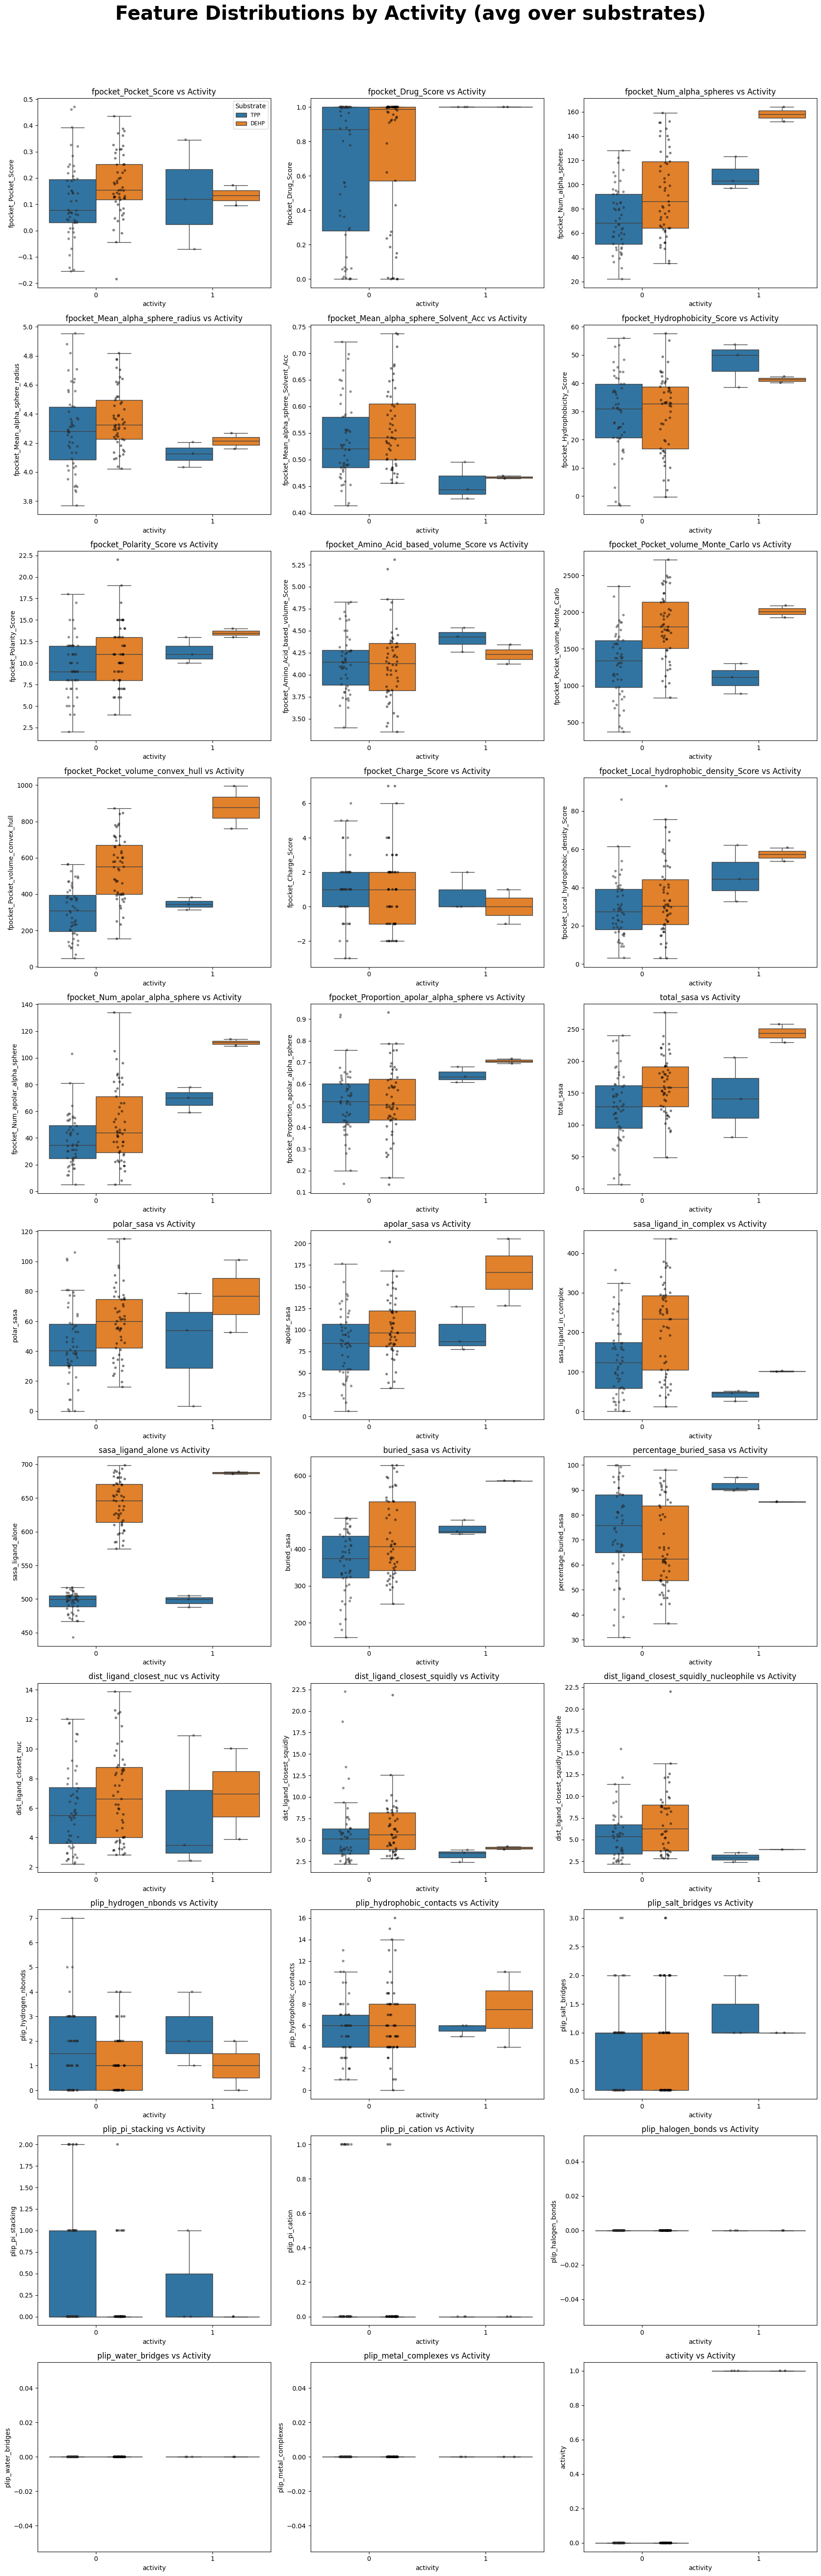

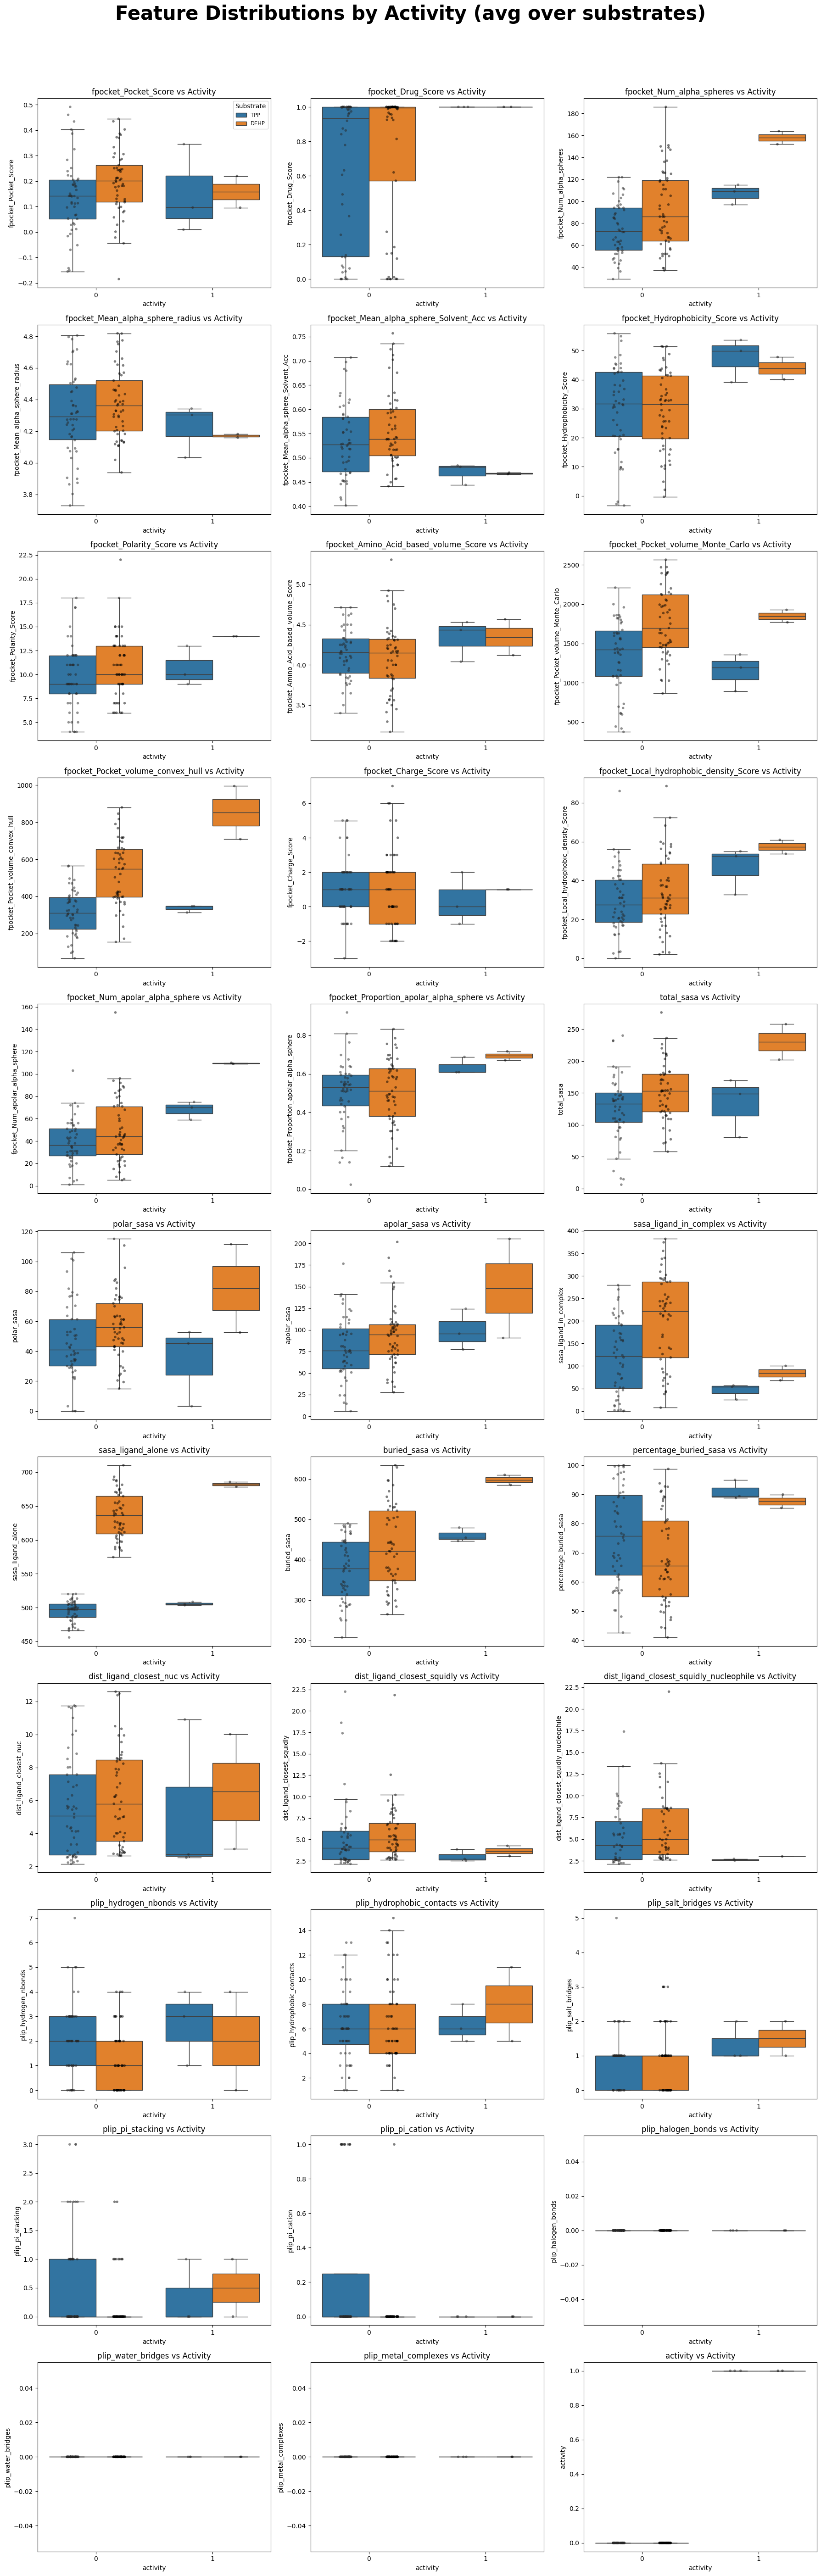

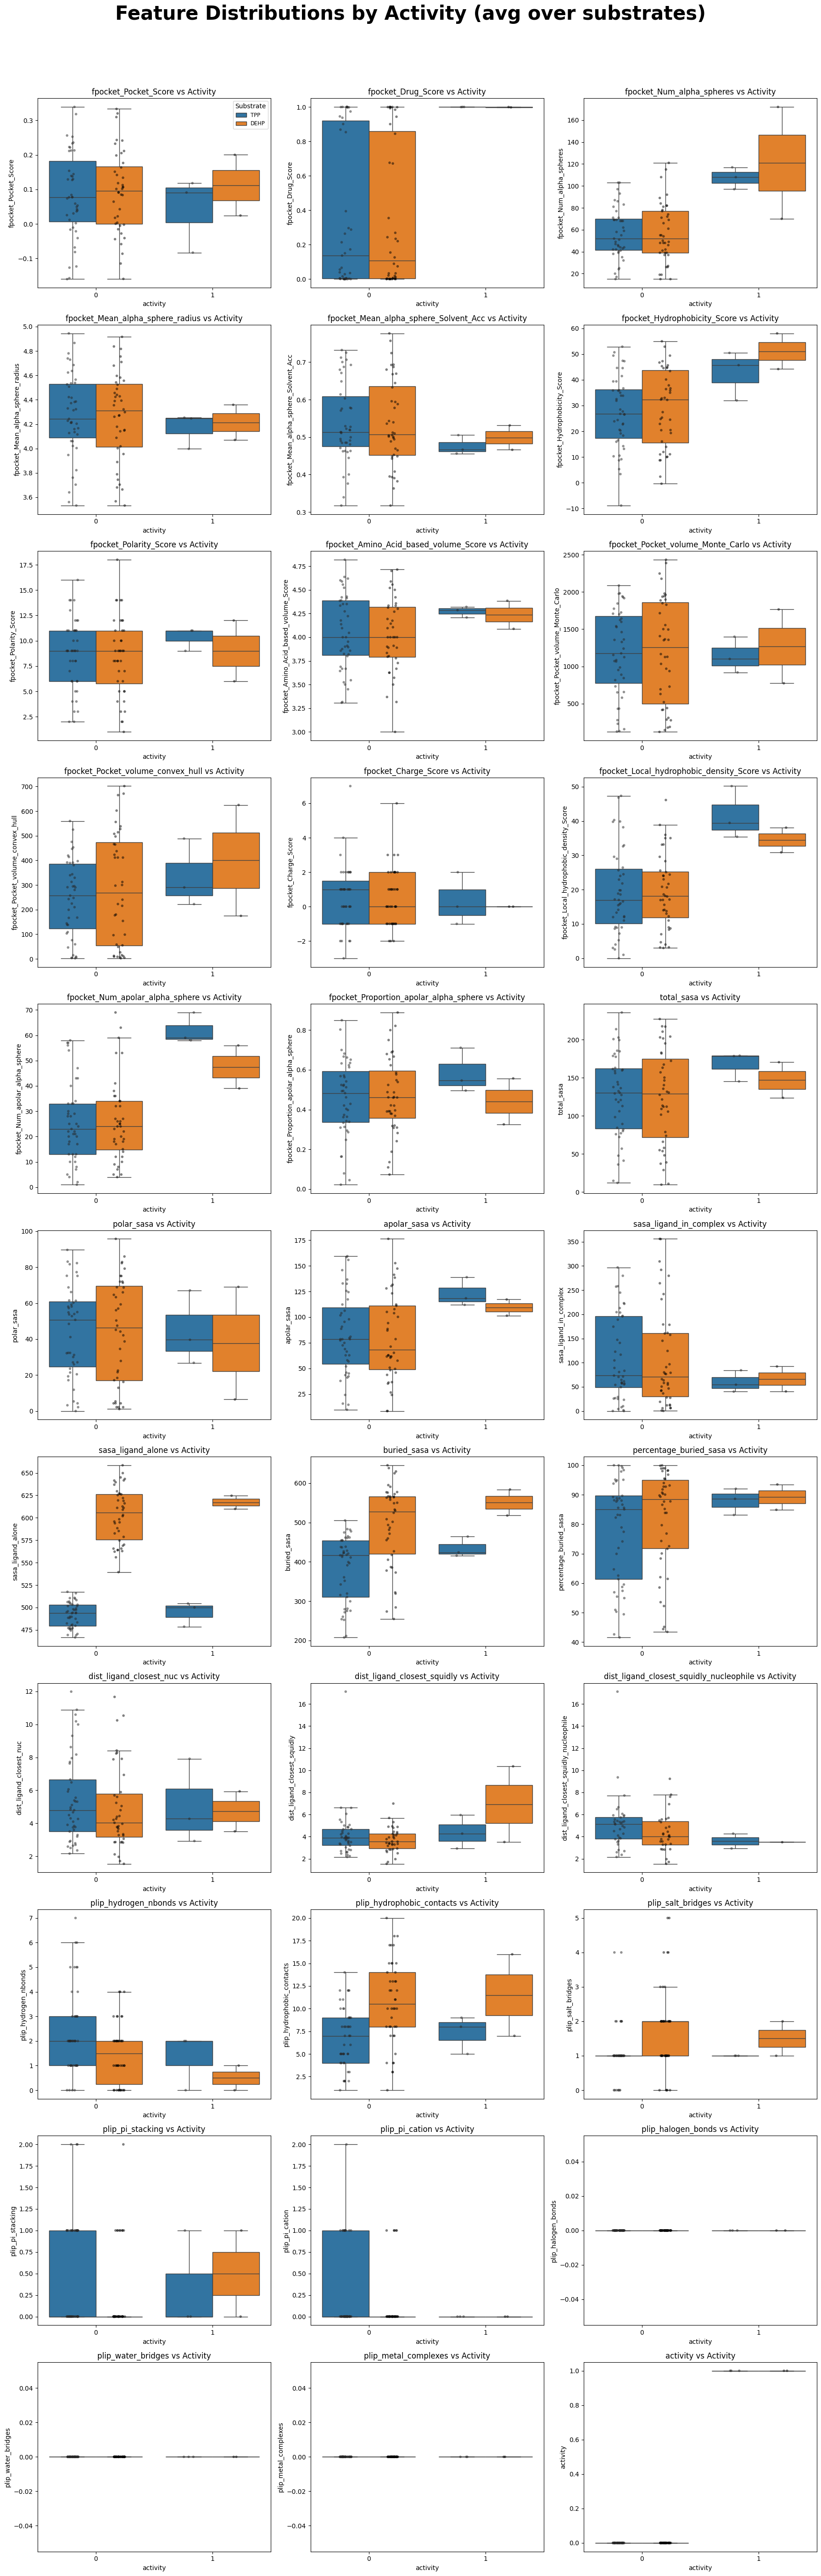

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



def feature_plots_per_substrate(df, features, method):

    # methods: inter_tool_weighted_avg, inter_tool_min_per_tool, vina_avg_intra_tool
    df = df[df['method'] == method]

    num_features = len(features)
    cols = 3  # plots per row
    rows = (num_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

    for i, col in enumerate(features):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        # Boxplot with dodge
        sns.boxplot(x='activity', y=col, hue='Substrate', data=df, ax=ax, 
                    showfliers=False, dodge=True)
        
        # Stripplot overlay with dodge
        sns.stripplot(x='activity', y=col, hue='Substrate', data=df, ax=ax, palette='dark:black',
                    dodge=True, jitter=True, size=4, alpha=0.5, legend=False)

        ax.set_title(f"{col} vs Activity")

        # Only show one legend per plot (optional)
        if i == 0:
            ax.legend(loc='best', fontsize='small', title='Substrate')
        else:
            ax.get_legend().remove()

    # Remove unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols] if rows > 1 else axes[j % cols])

    fig.suptitle("Feature Distributions by Activity (avg over substrates)", fontsize=30, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()



def feature_plots_avg(df, features, method):

    # methods: inter_tool_weighted_avg, inter_tool_min_per_tool, vina_avg_intra_tool
    df = df[df['method'] == method]

    num_features = len(features)
    cols = 3  # plots per row
    rows = (num_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

    for i, col in enumerate(features):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]

        # Boxplot without hue — combines all substrates
        sns.boxplot(x='activity', y=col, data=df, ax=ax, showfliers=False)

        # Stripplot overlay without hue
        sns.stripplot(x='activity', y=col, hue='activity', data=df, ax=ax, palette='dark:black',
                    jitter=True, size=4, alpha=0.5)

        ax.set_title(f"{col} vs Activity")

    # Remove unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols] if rows > 1 else axes[j % cols])

    fig.suptitle("Feature Distributions by Activity (avg over substrates)", fontsize=30, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()



feature_plots_per_substrate(df, features, 'inter_tool_weighted_avg')
feature_plots_per_substrate(df, features, 'inter_tool_min_per_tool')
feature_plots_per_substrate(df, features, 'vina_avg_intra_tool')
#feature_plots_avg(df, features)

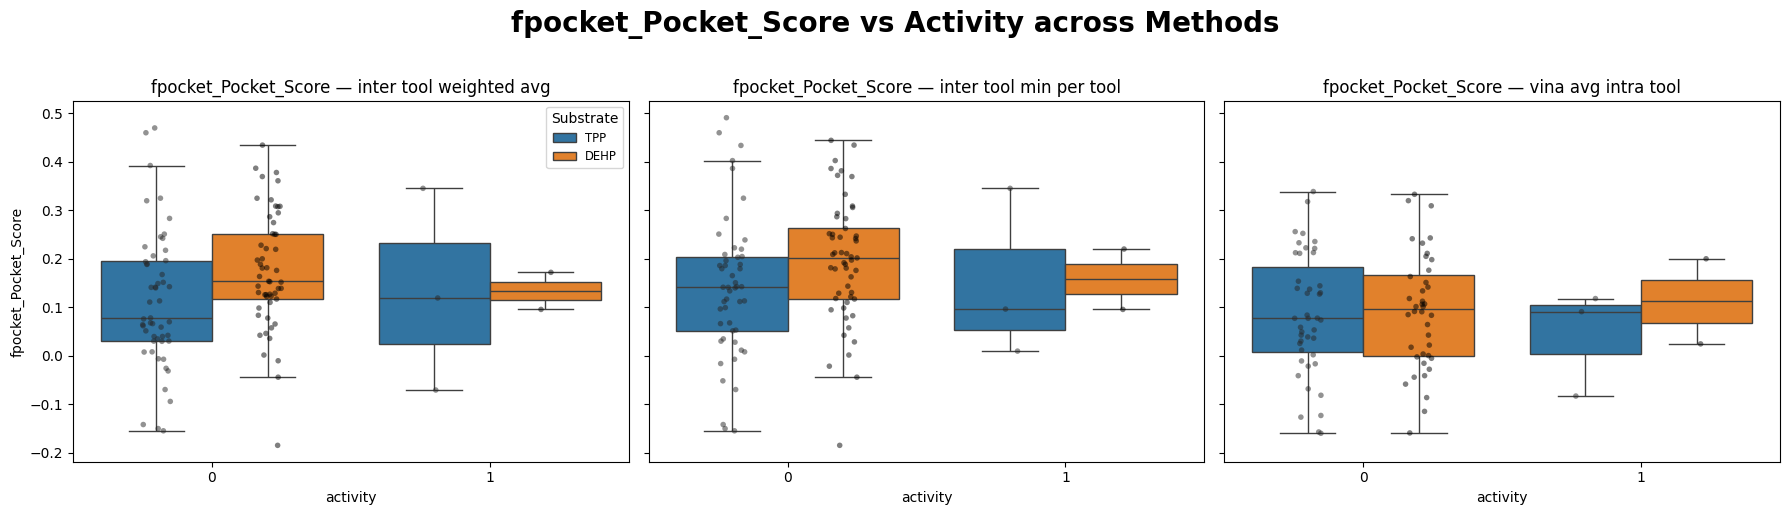

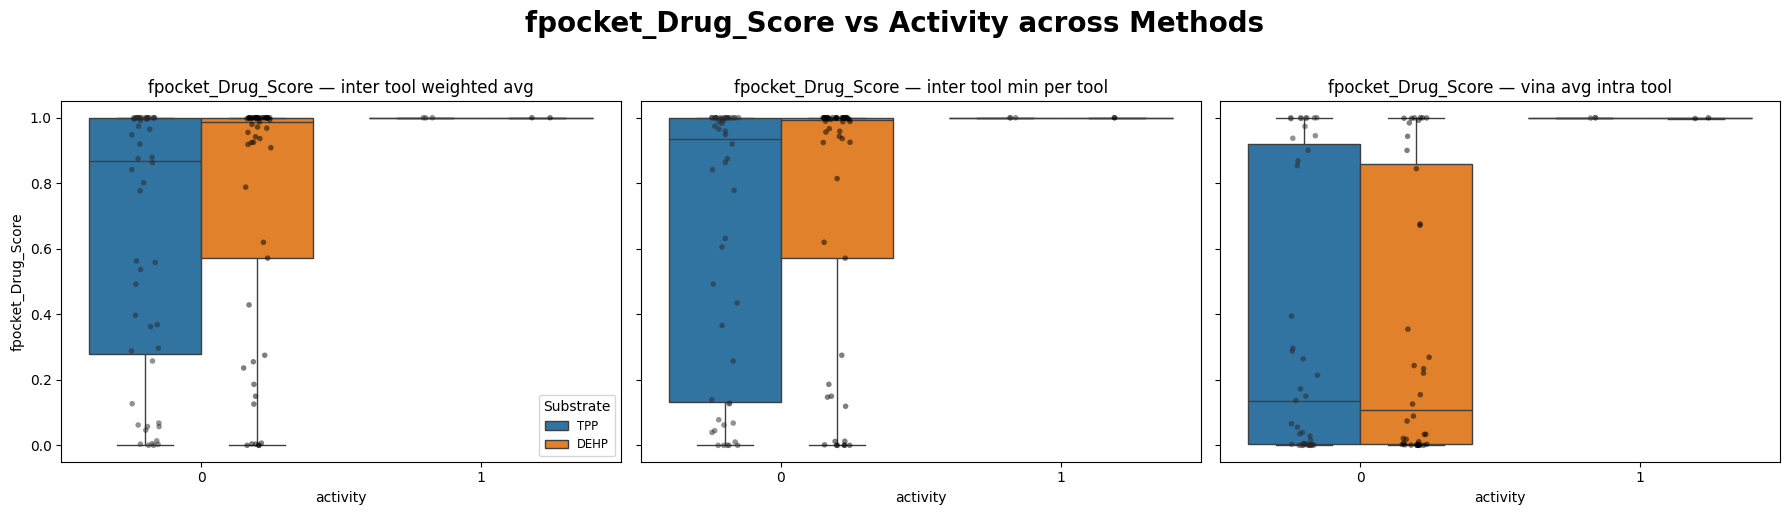

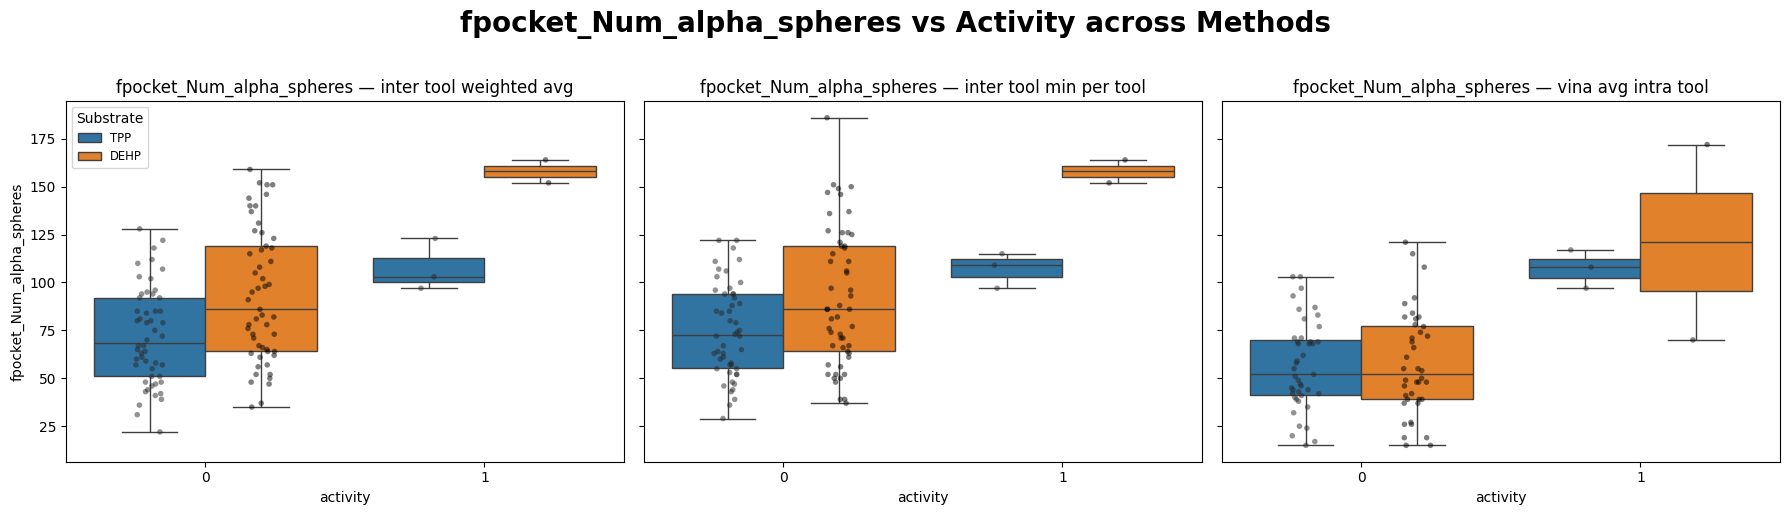

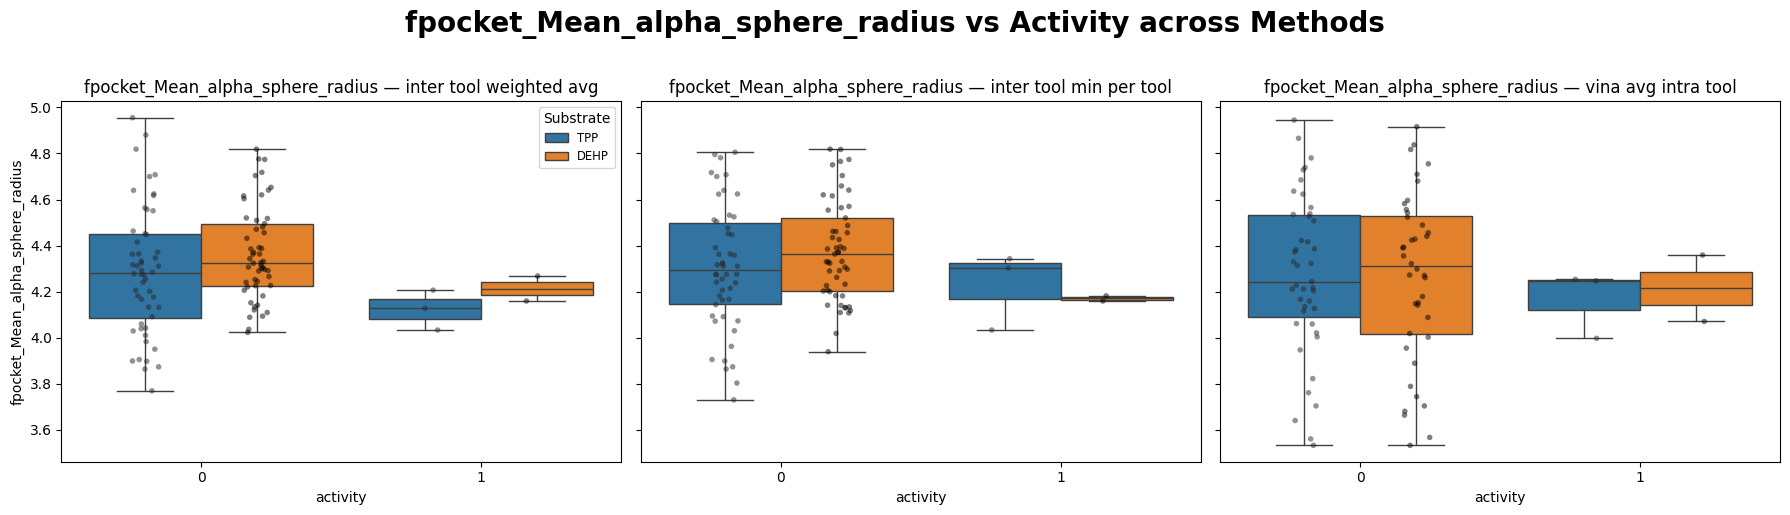

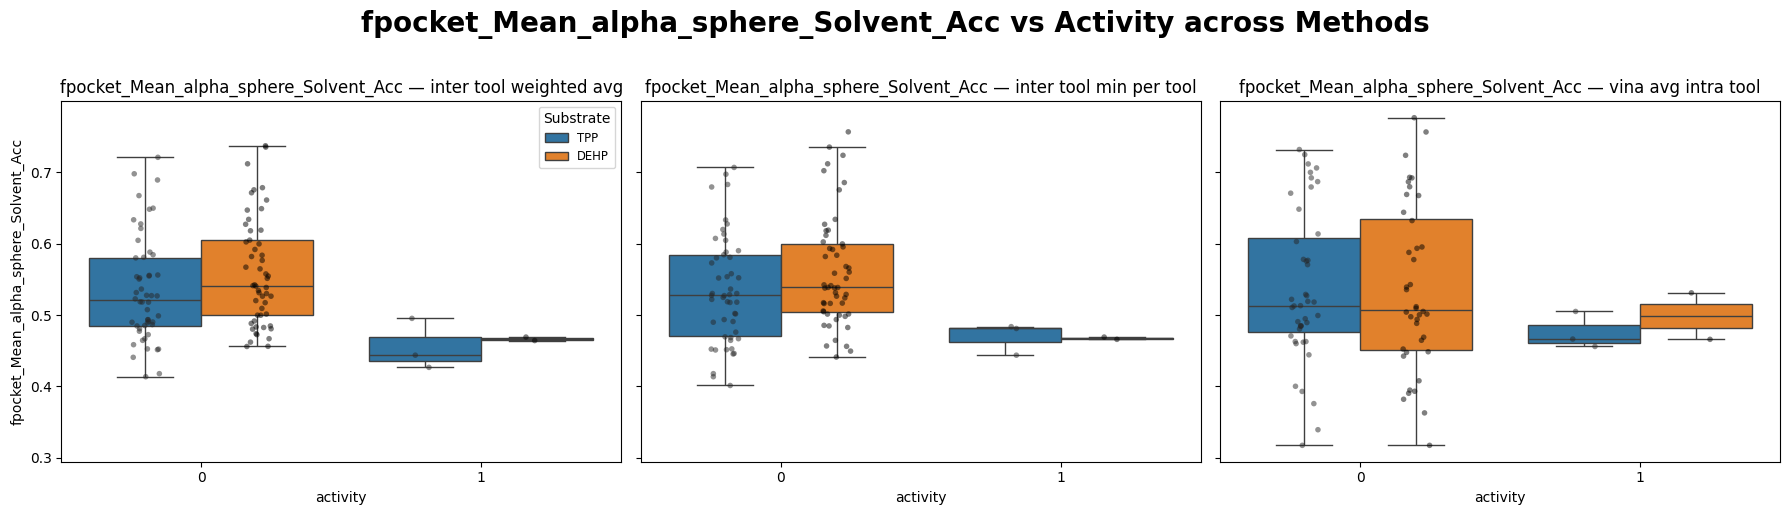

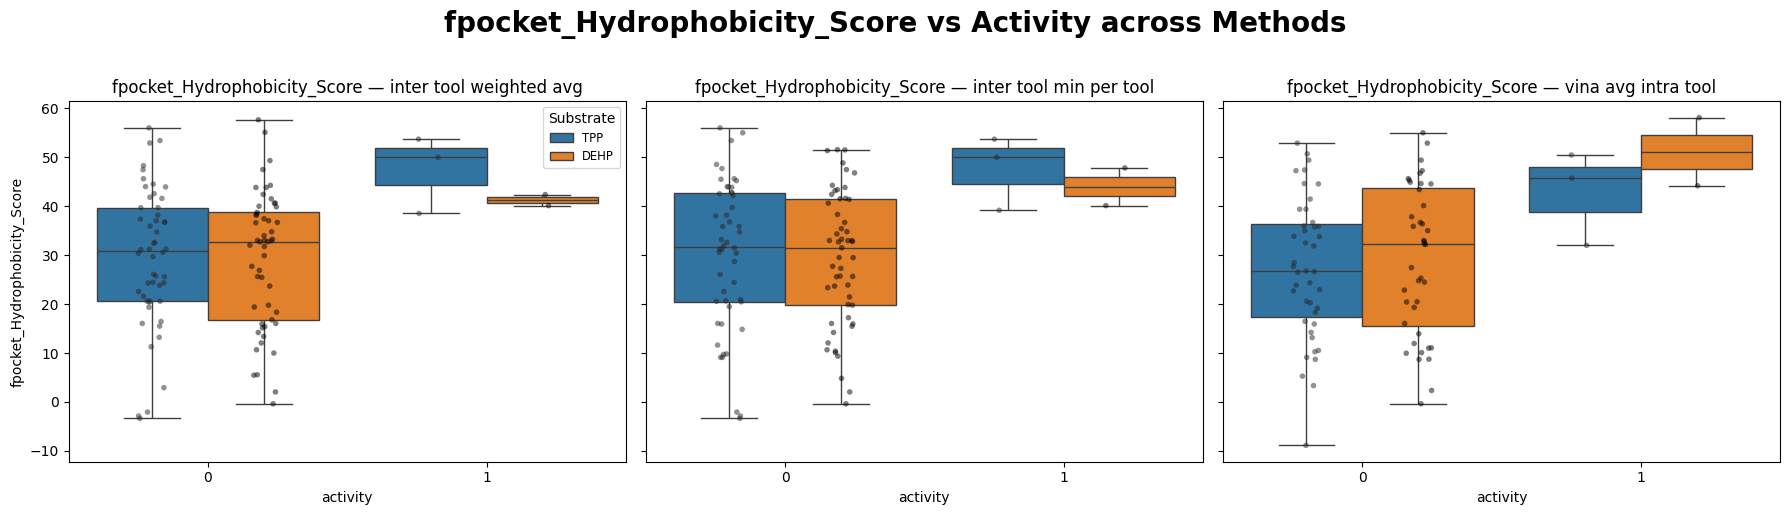

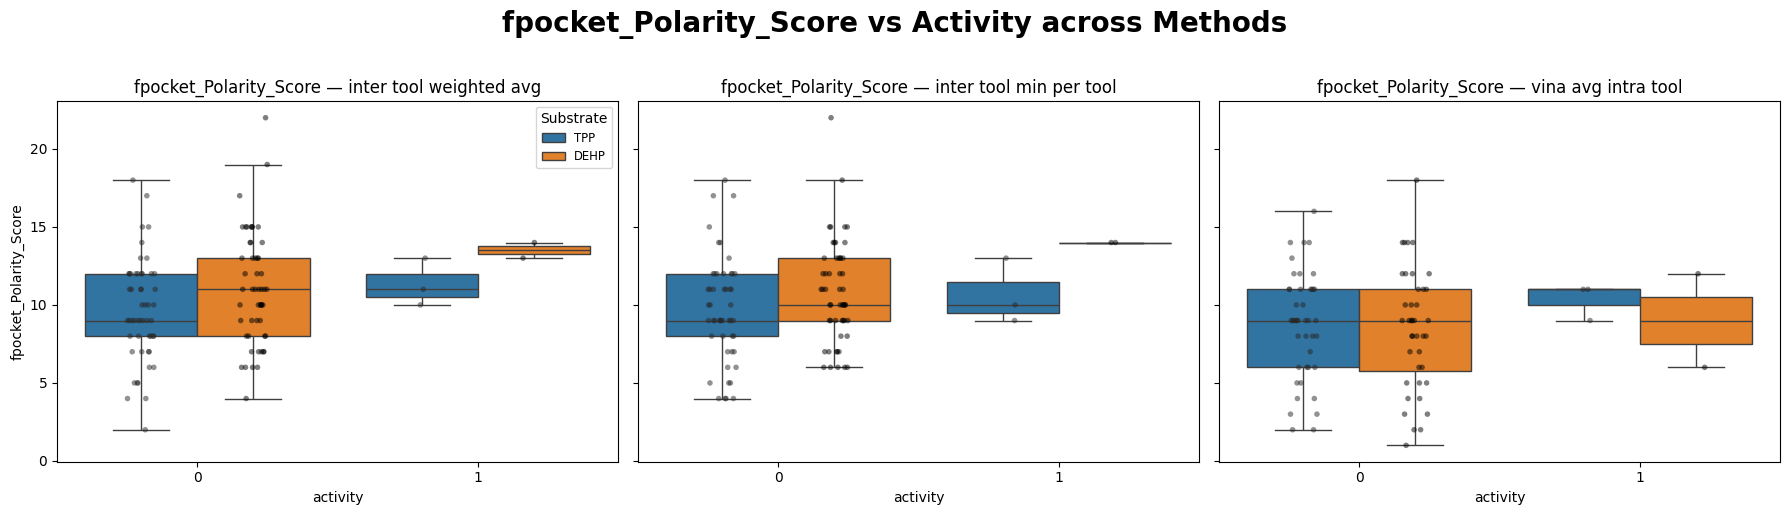

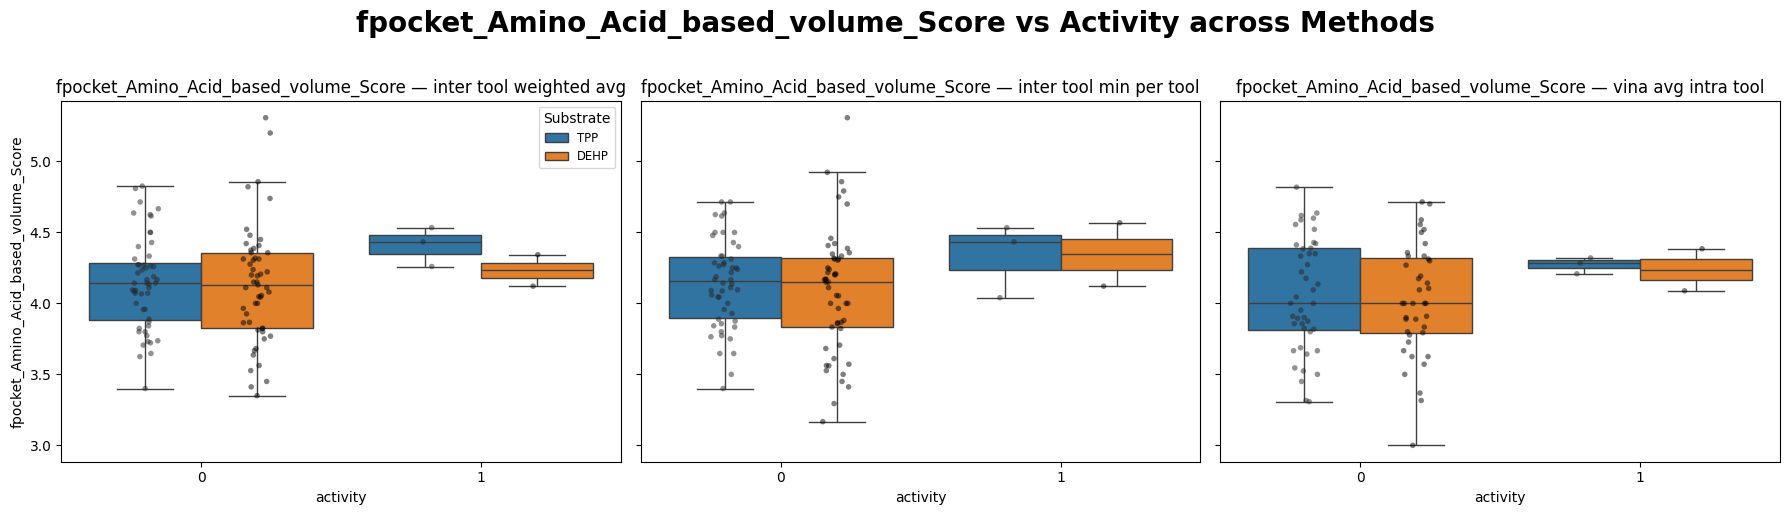

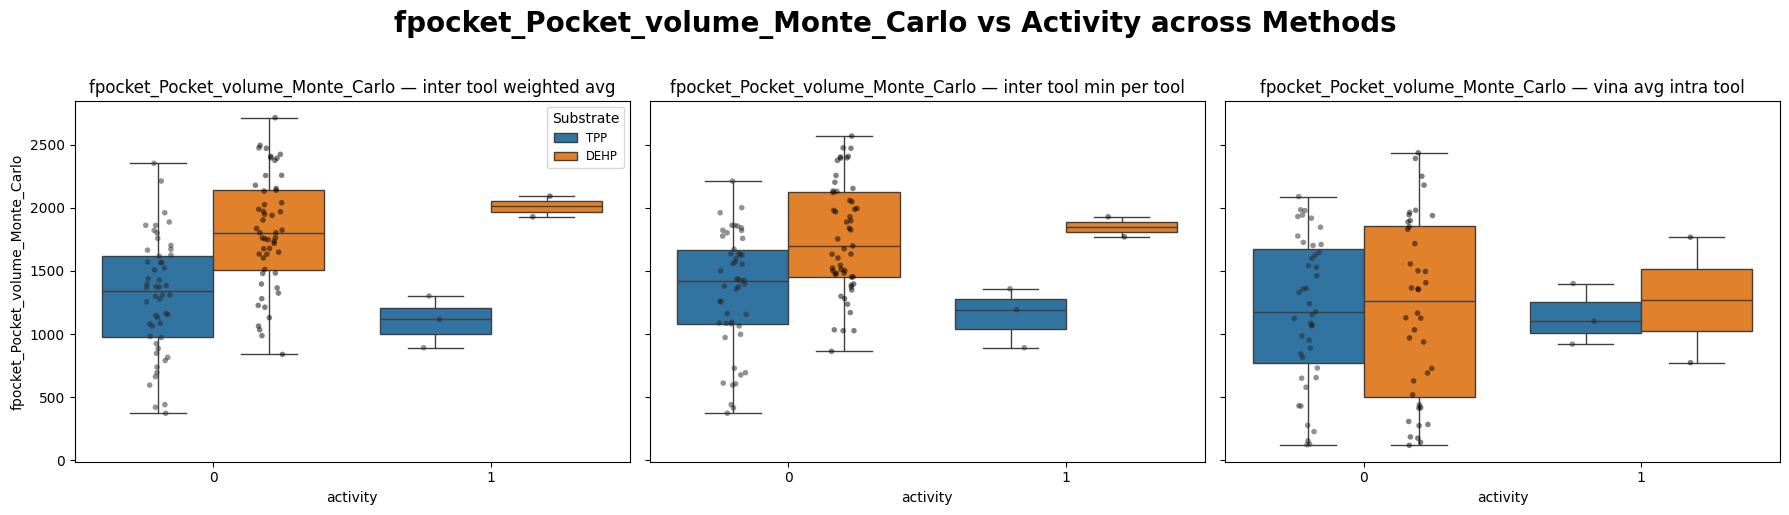

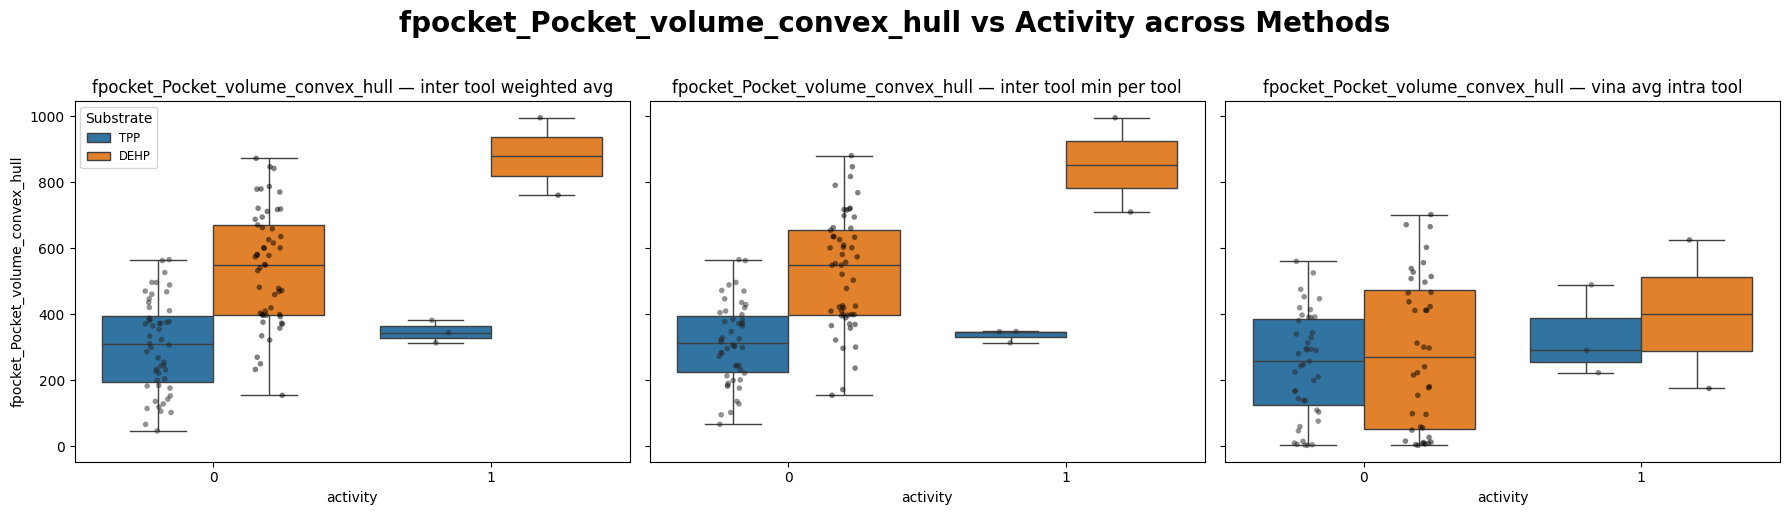

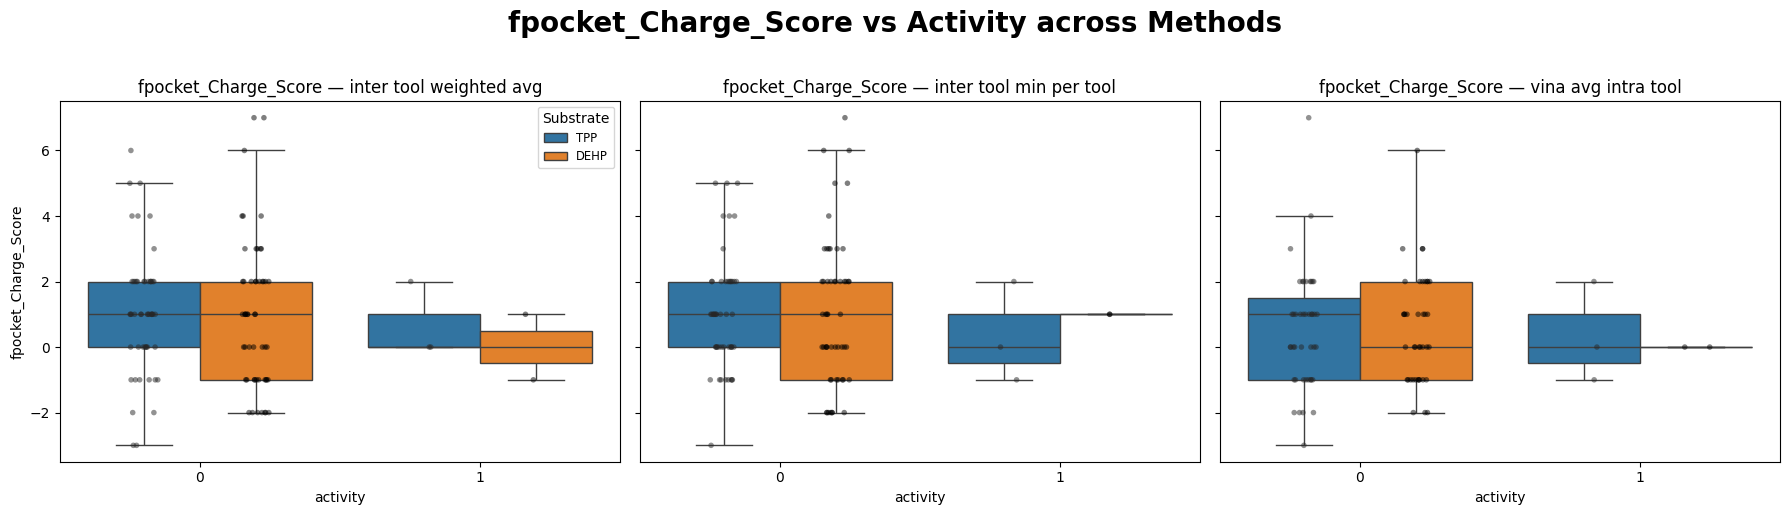

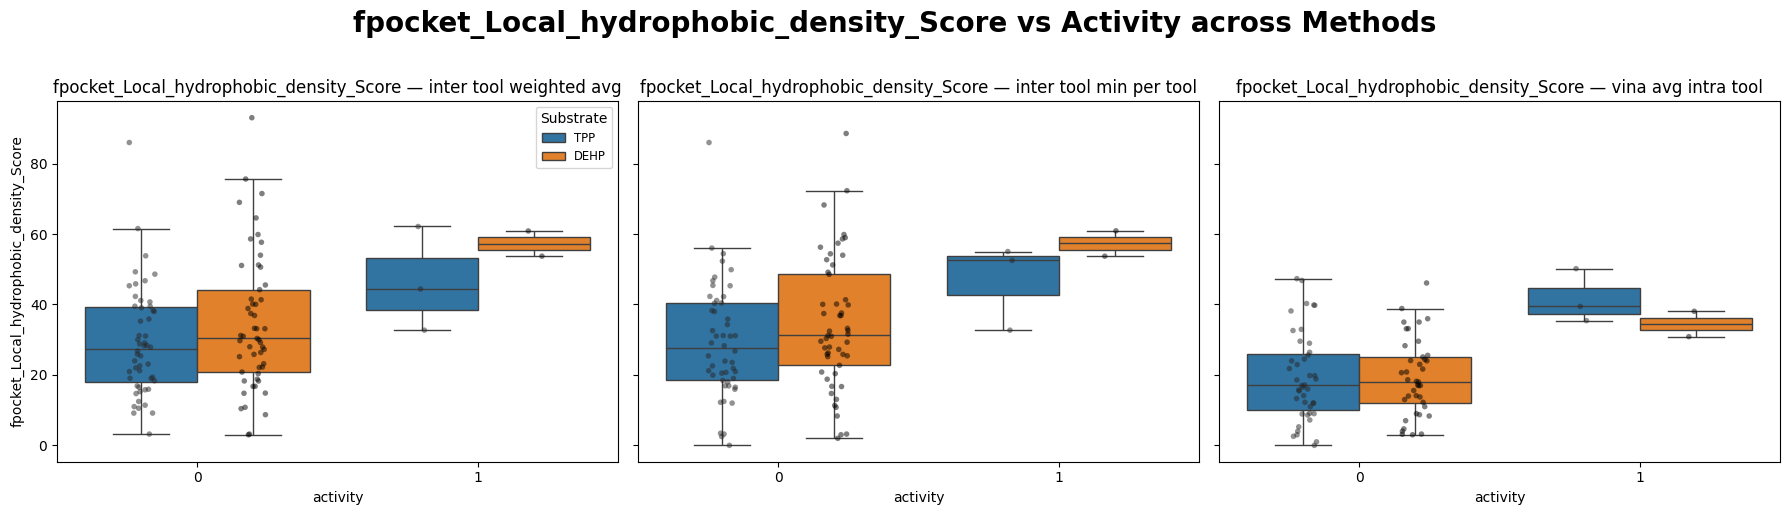

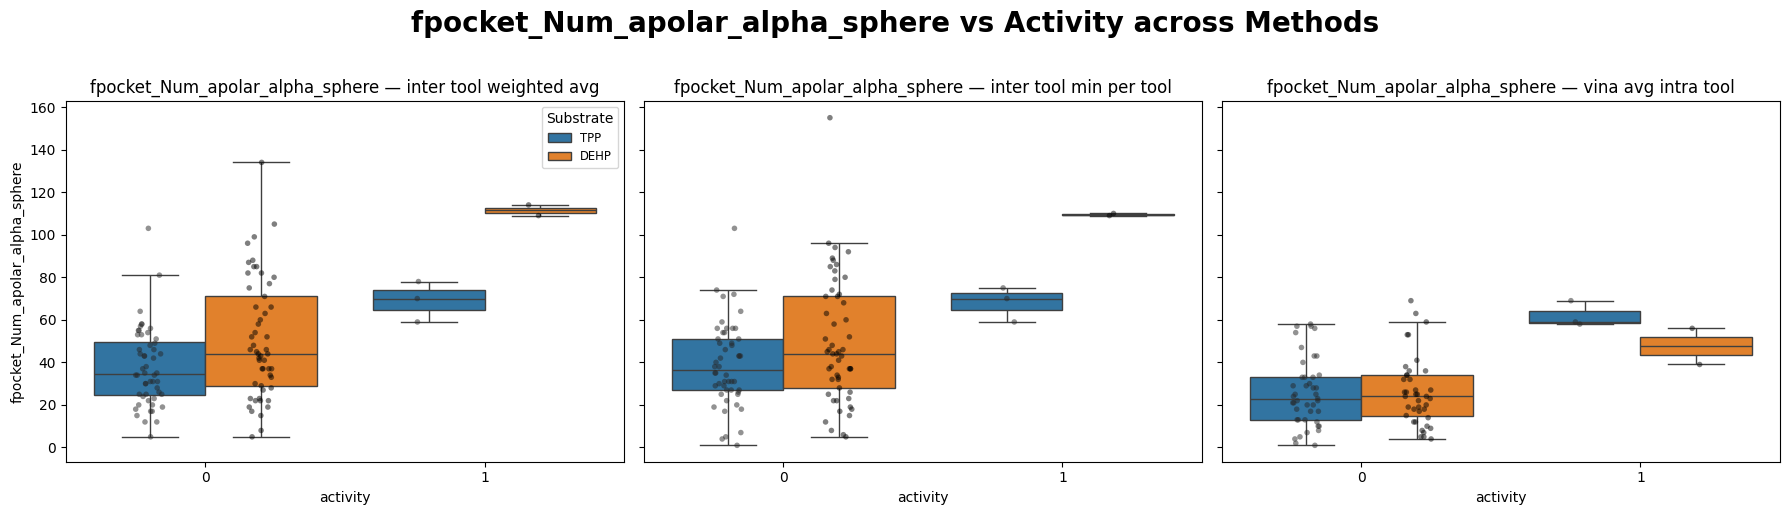

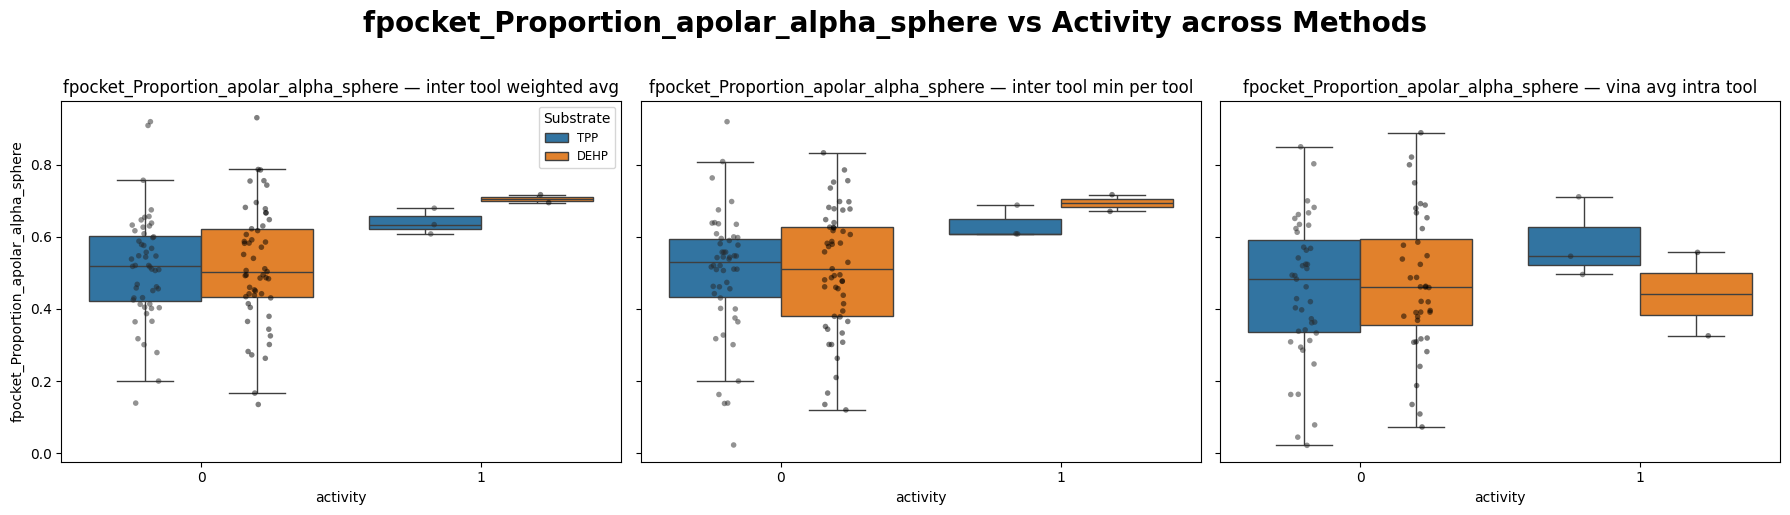

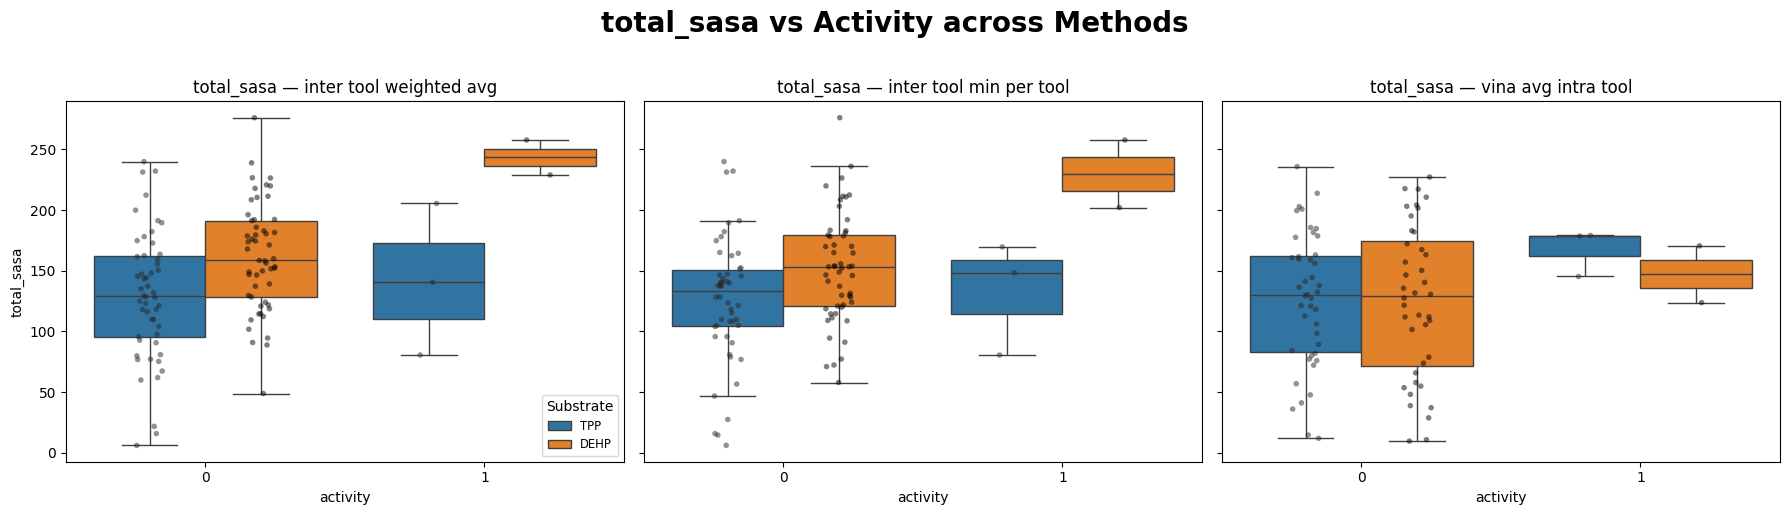

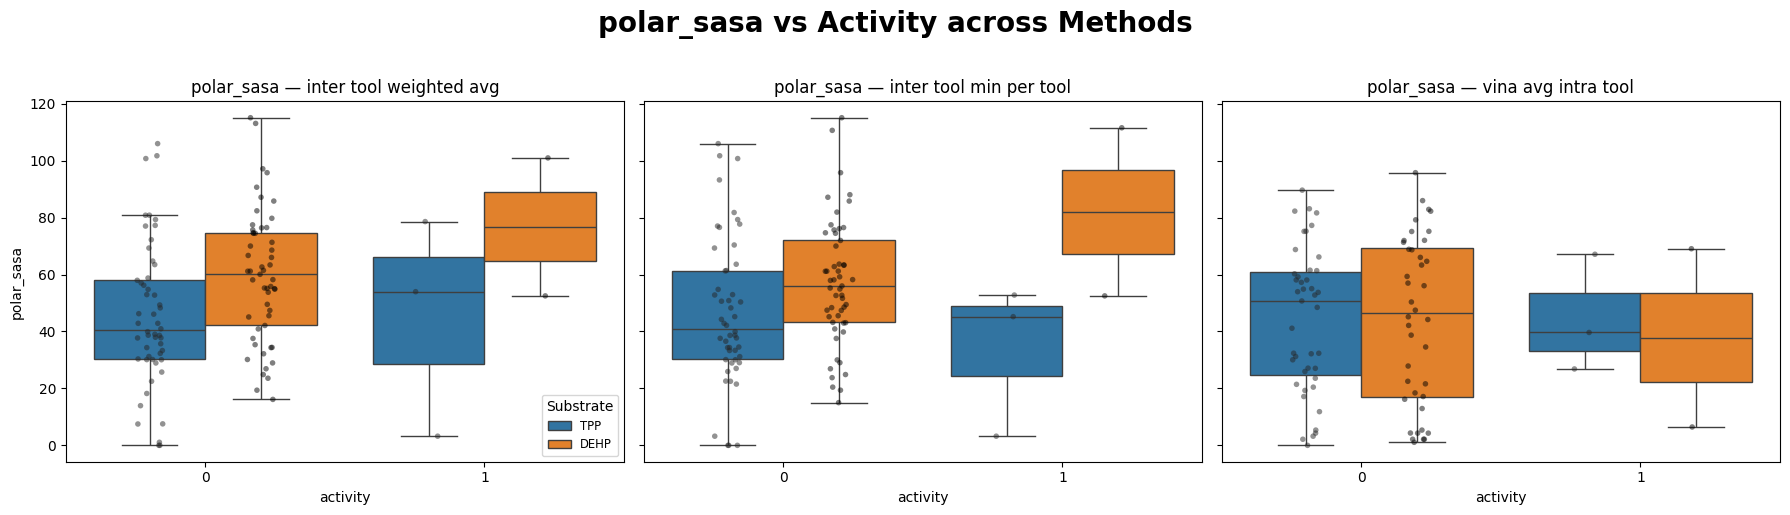

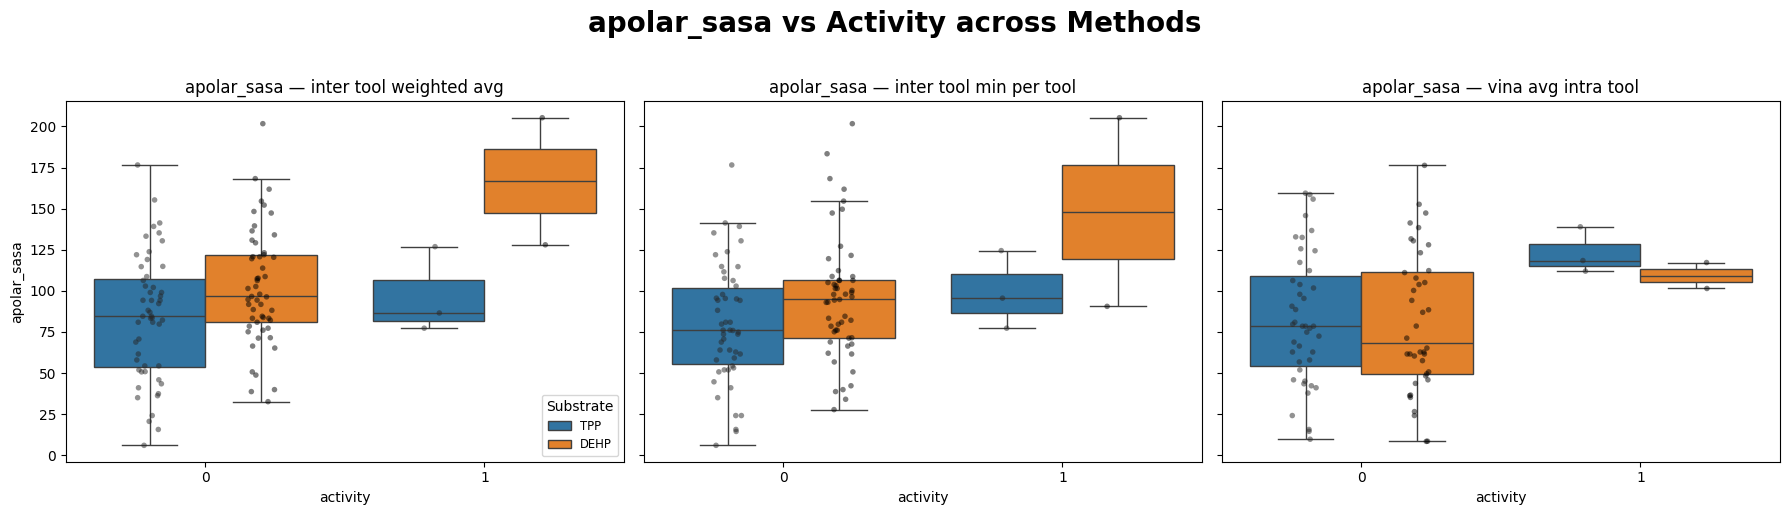

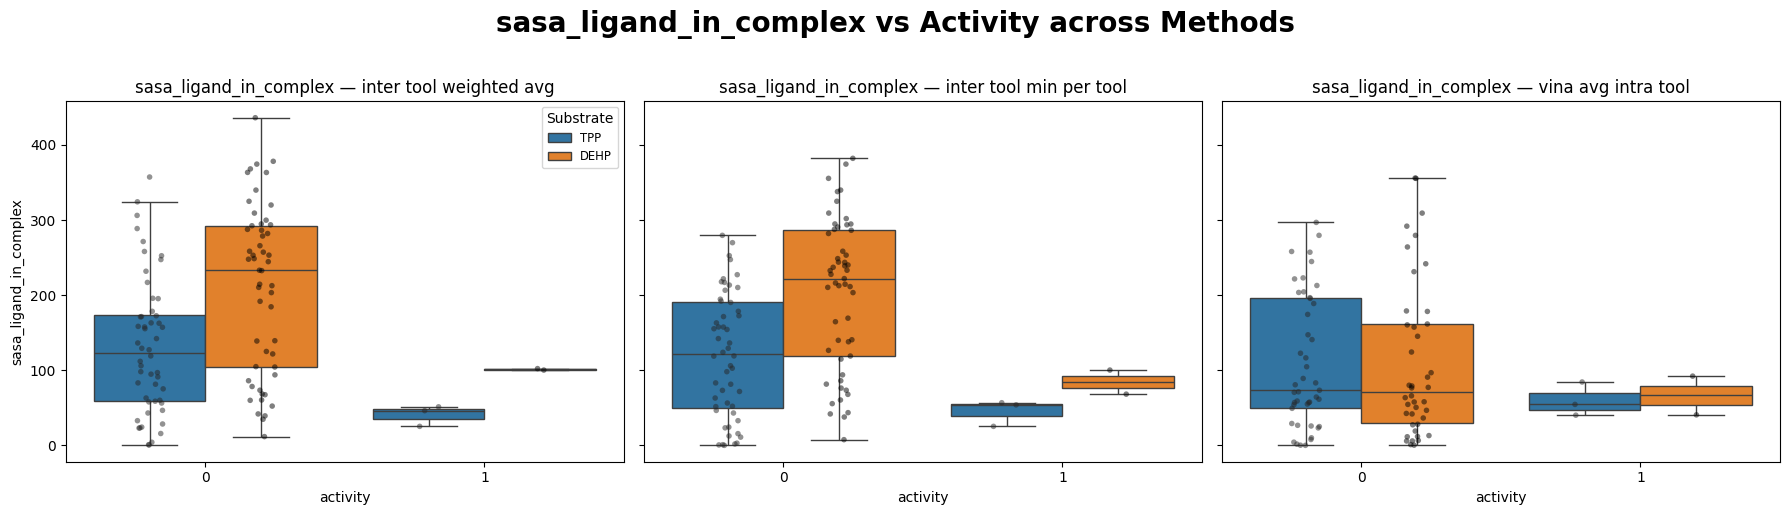

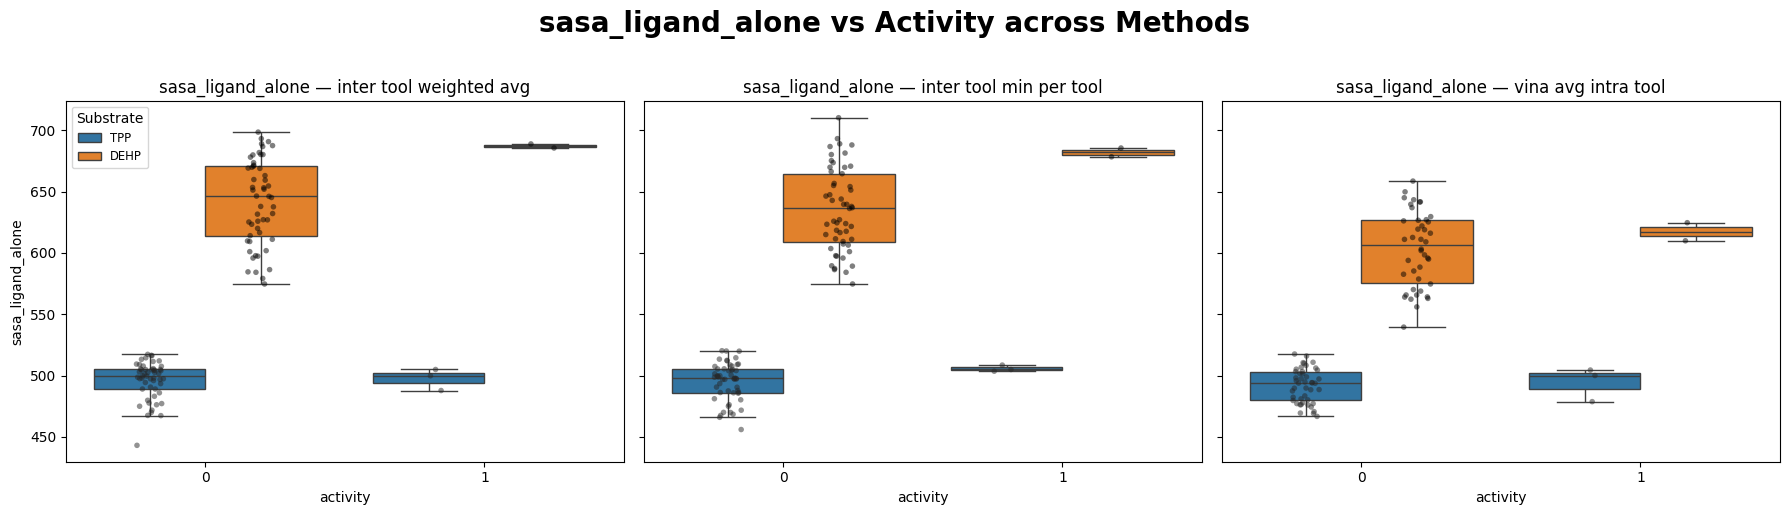

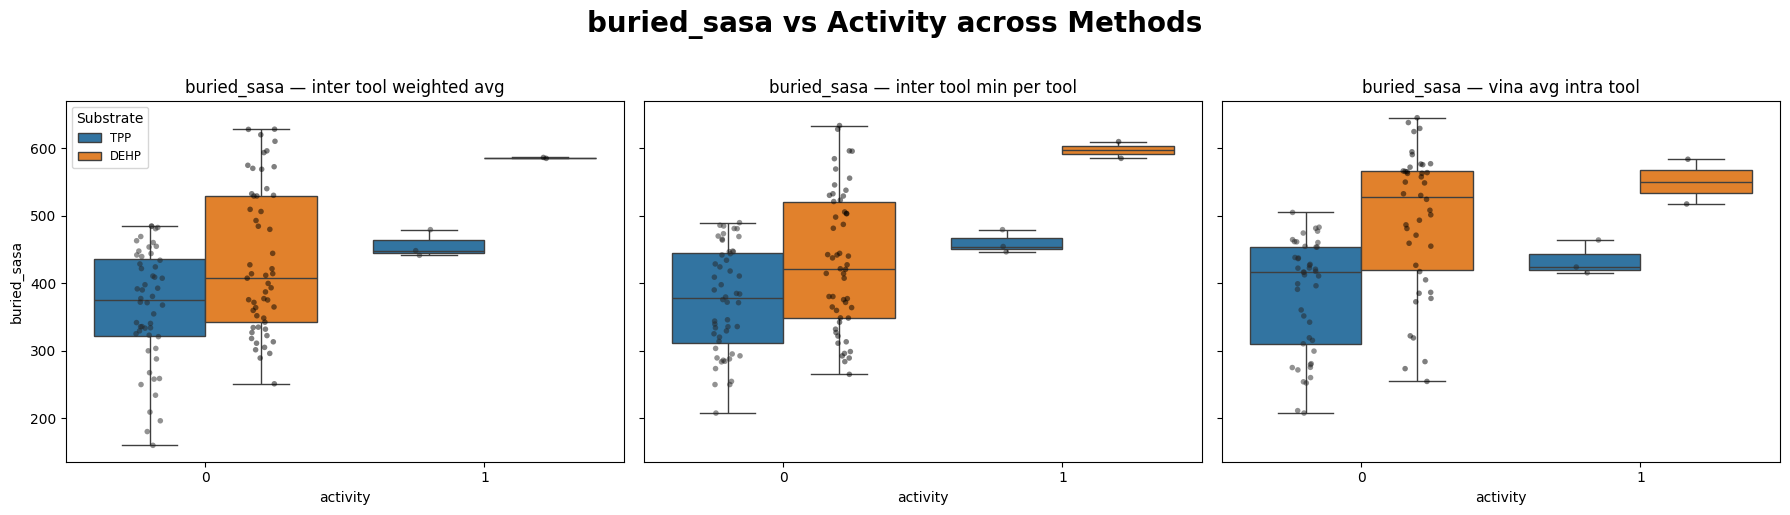

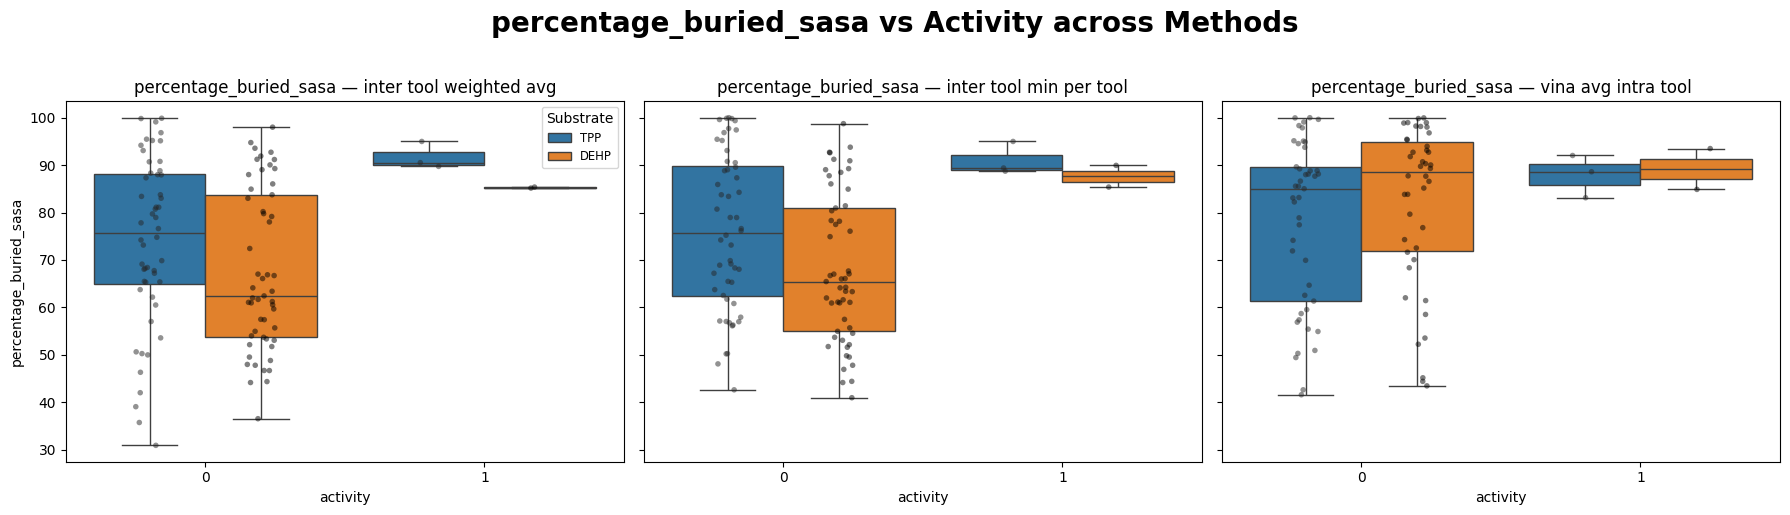

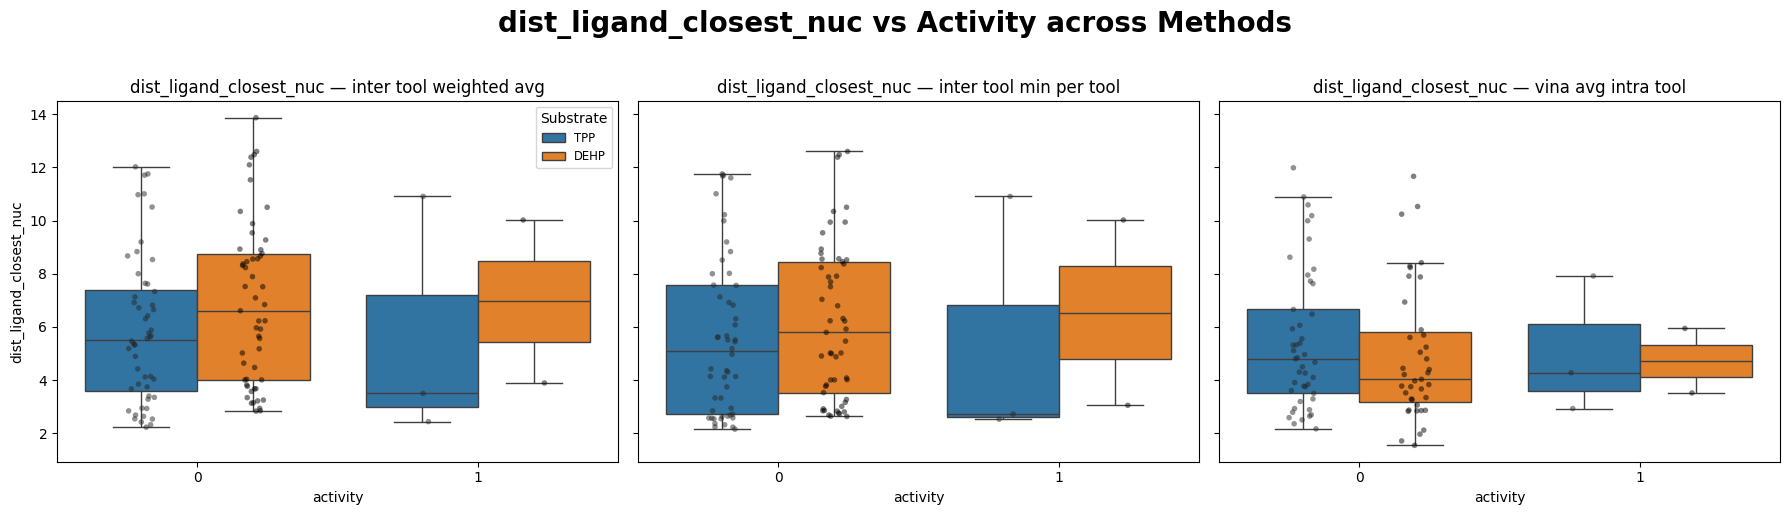

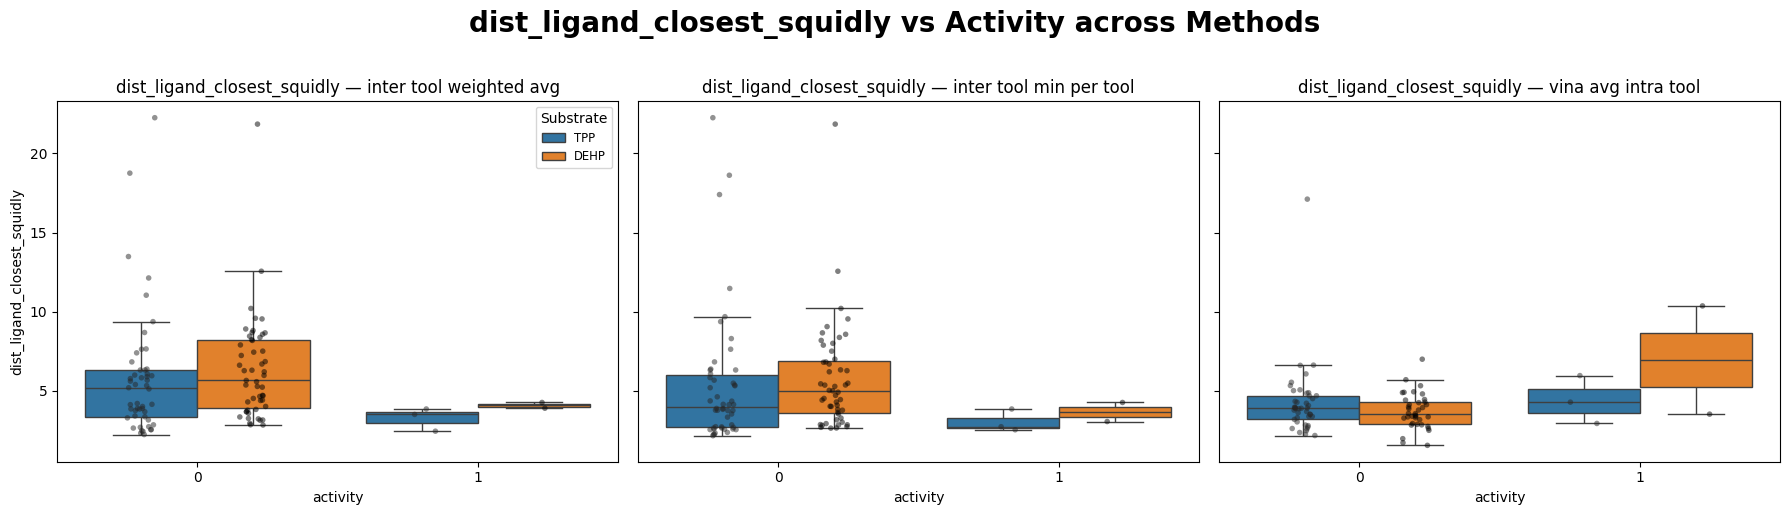

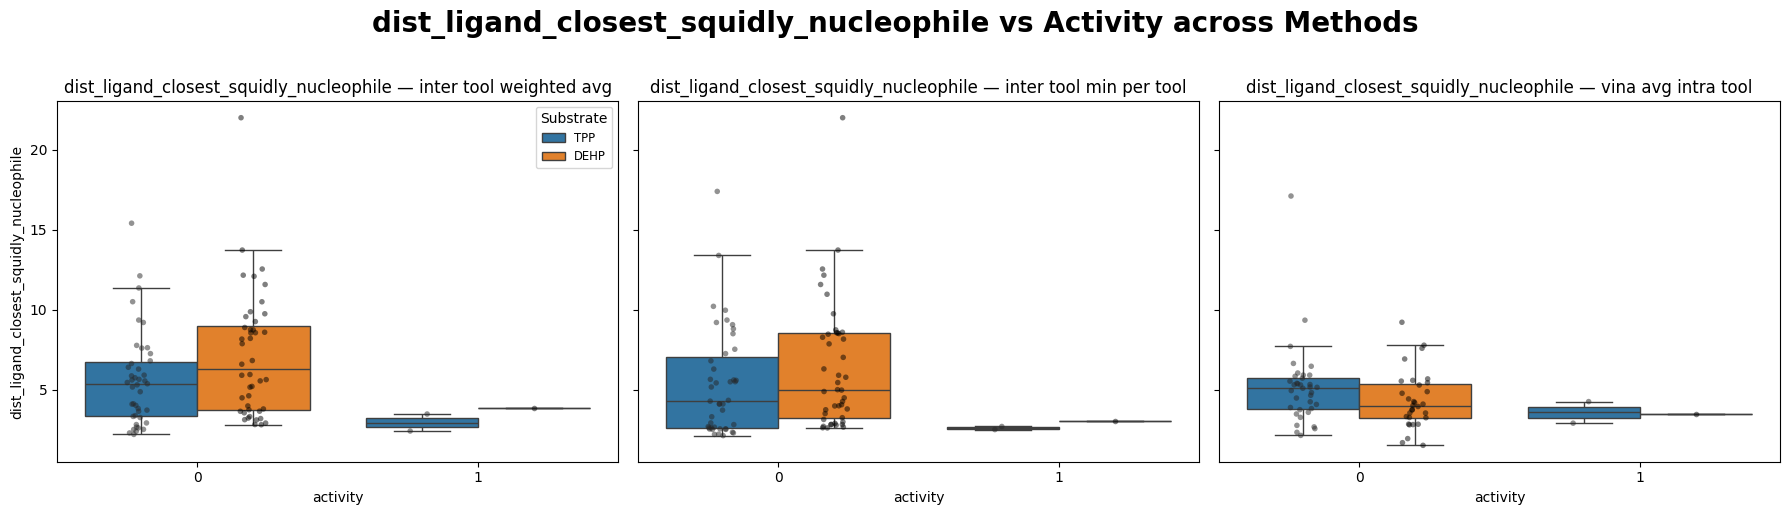

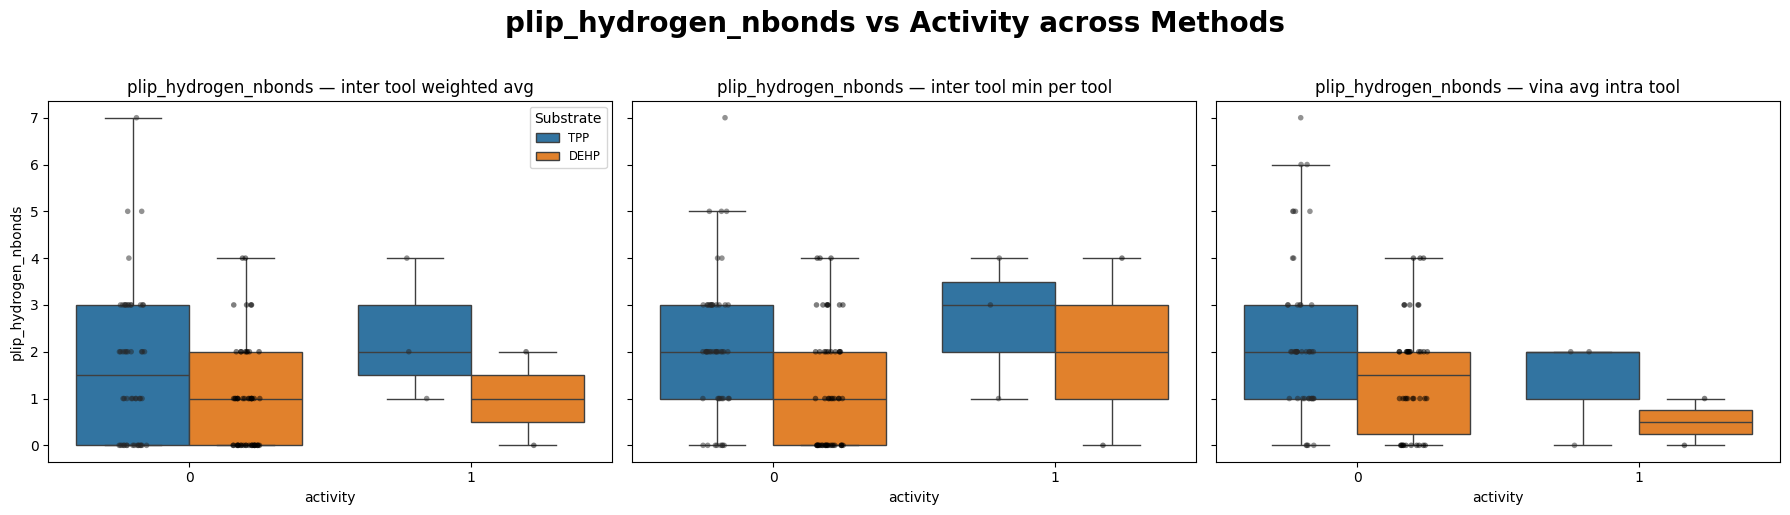

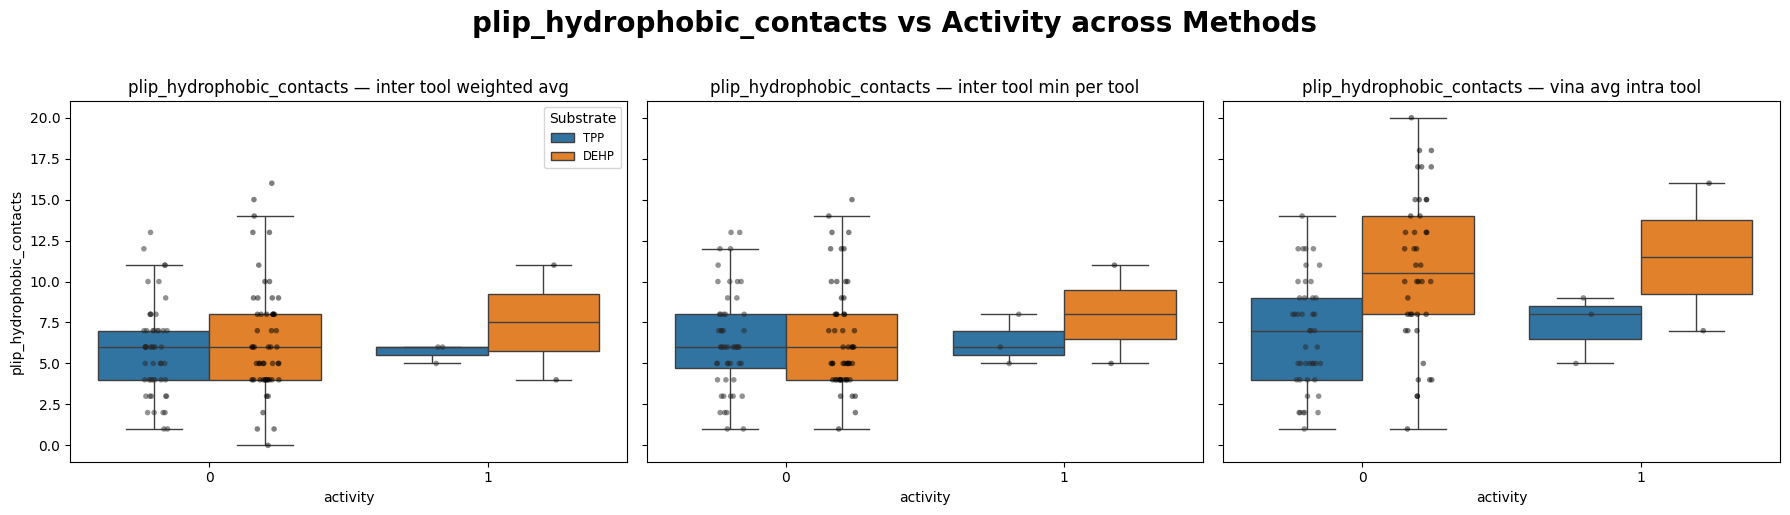

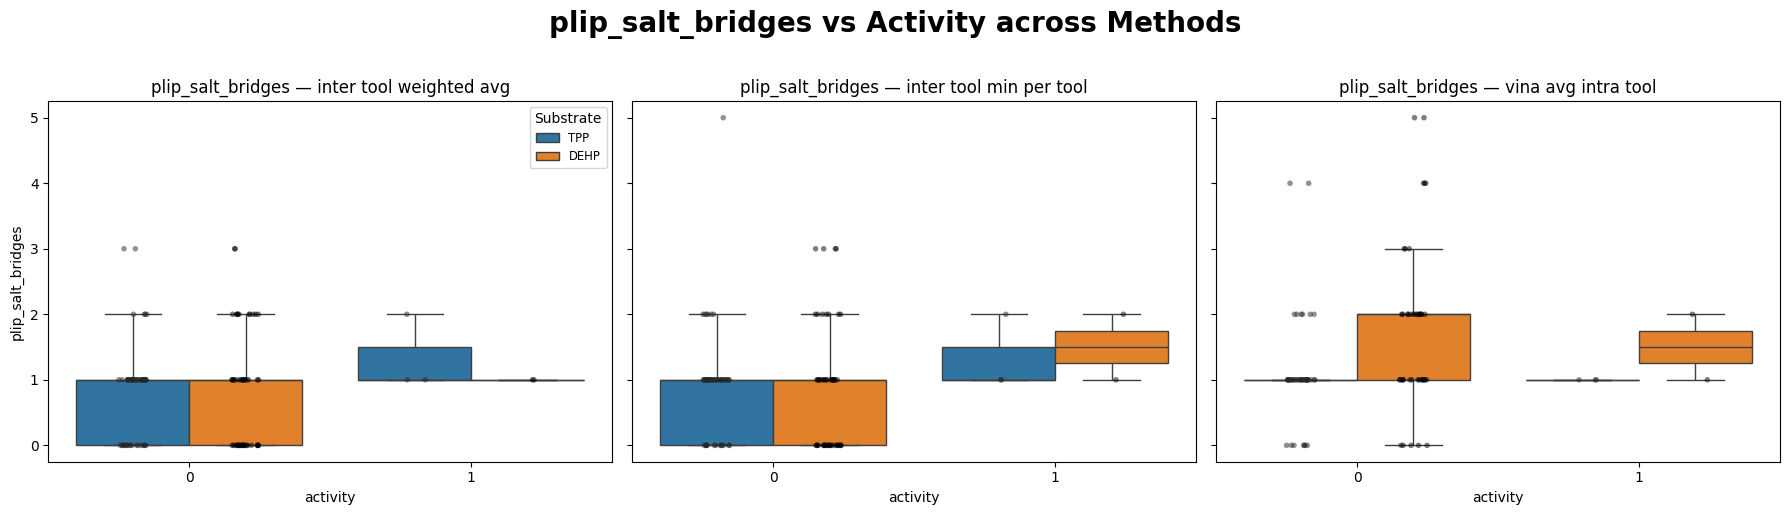

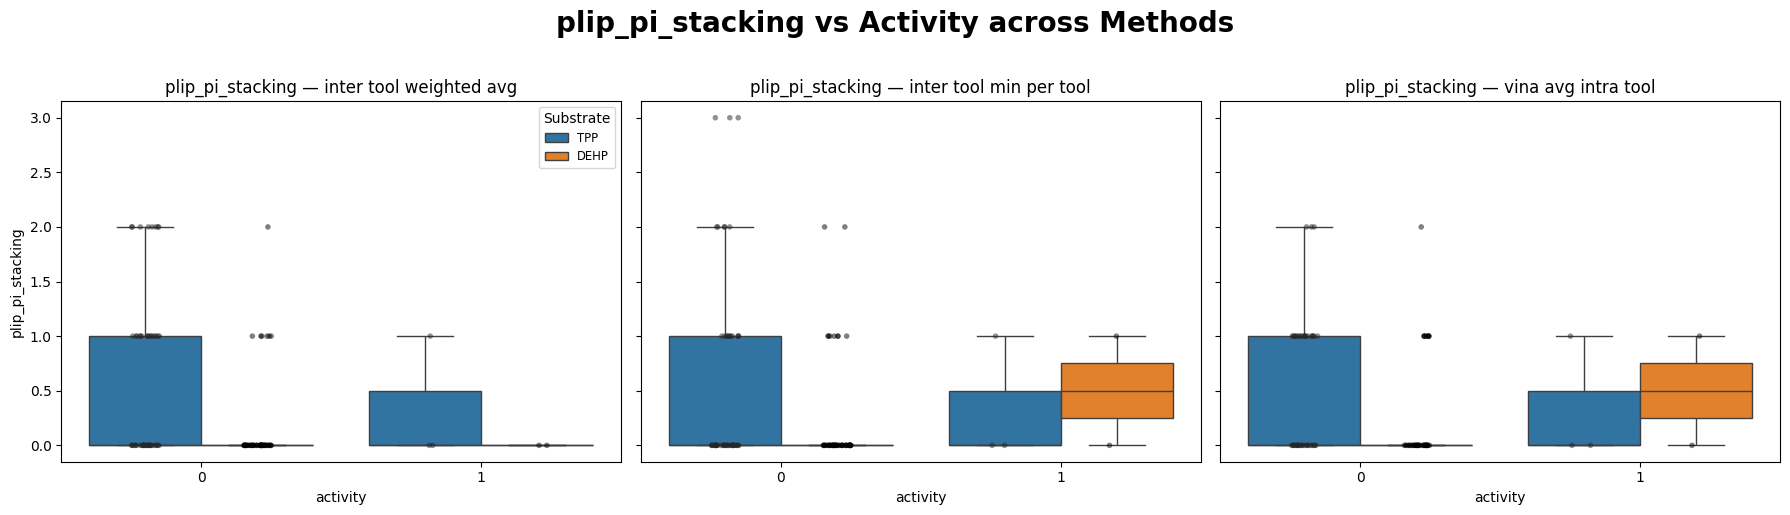

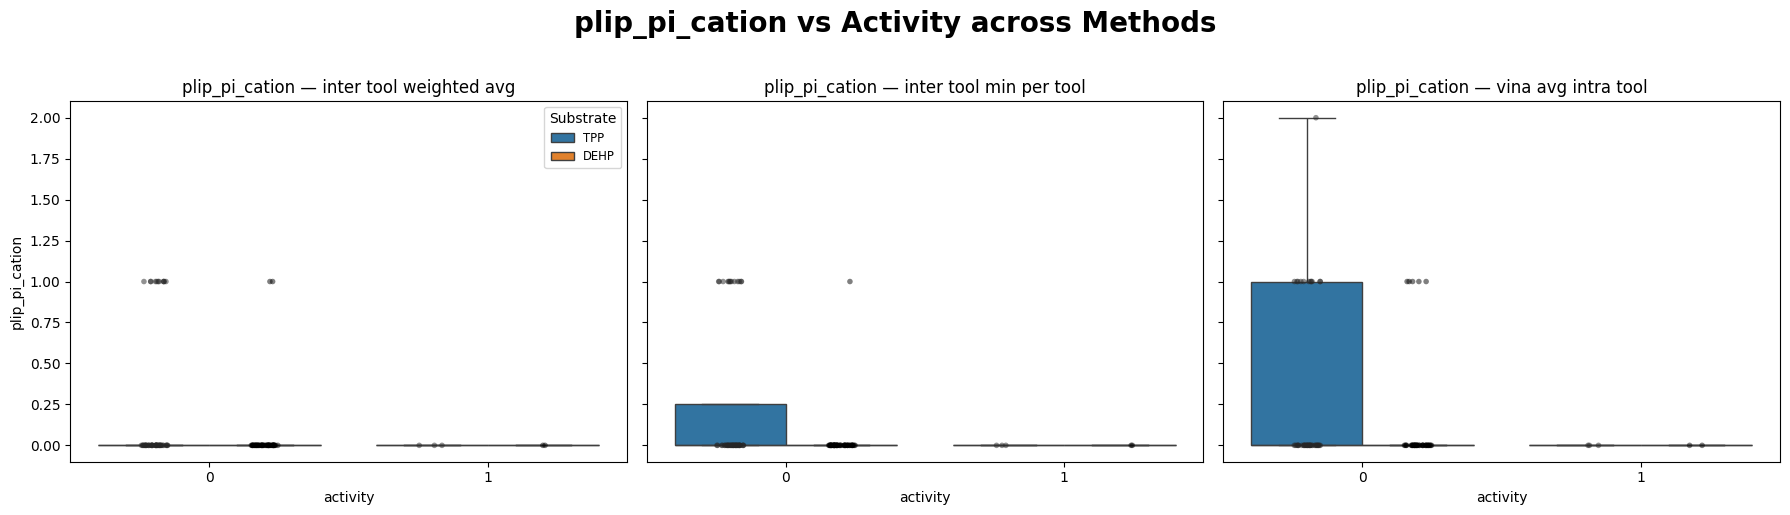

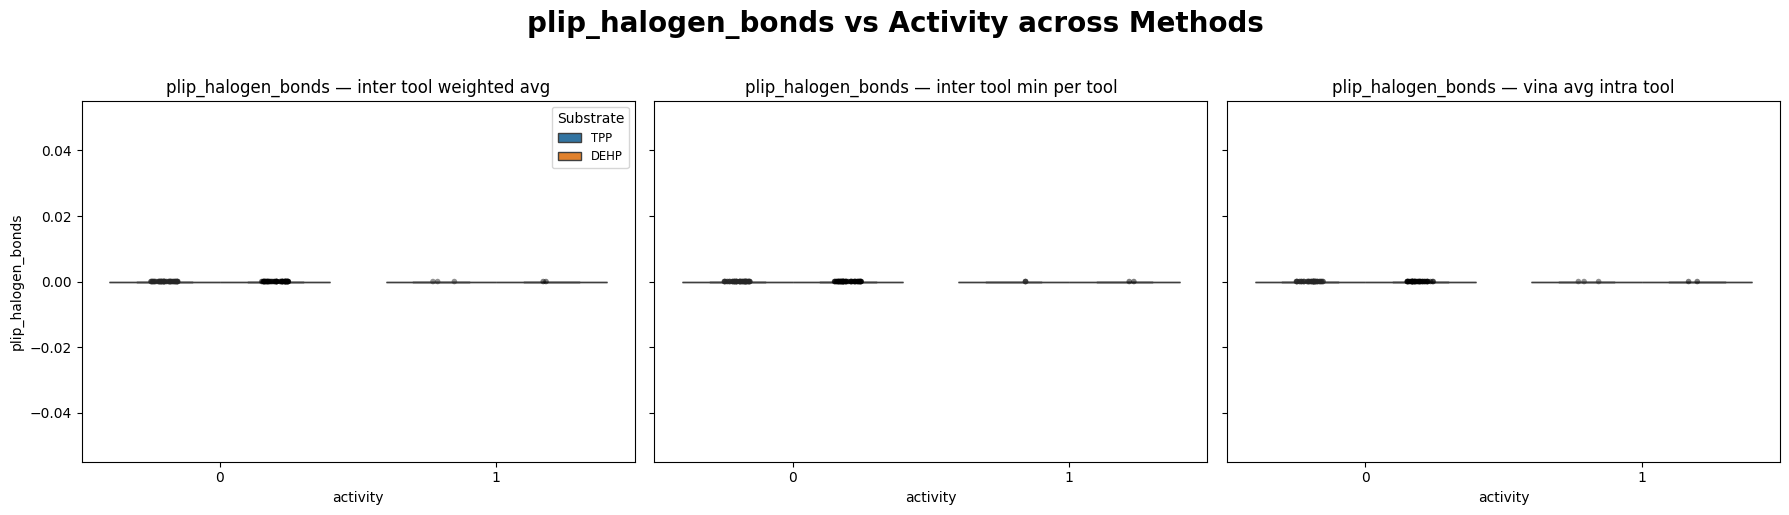

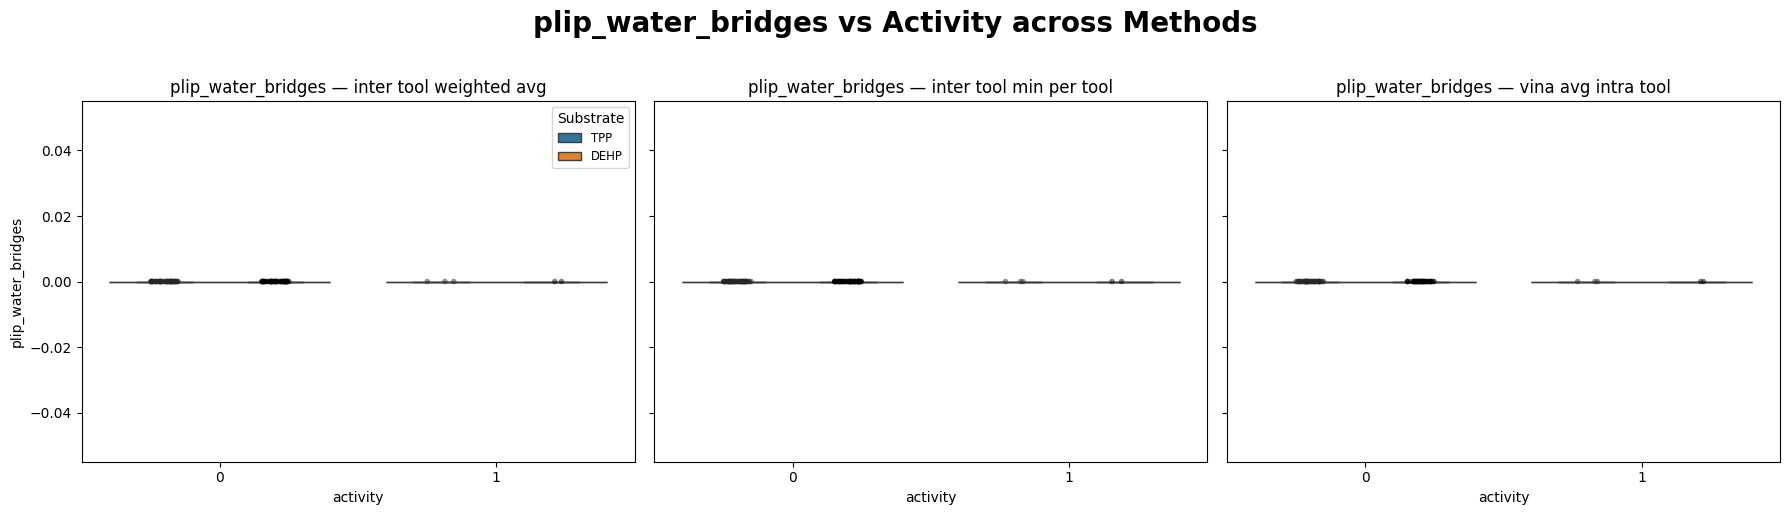

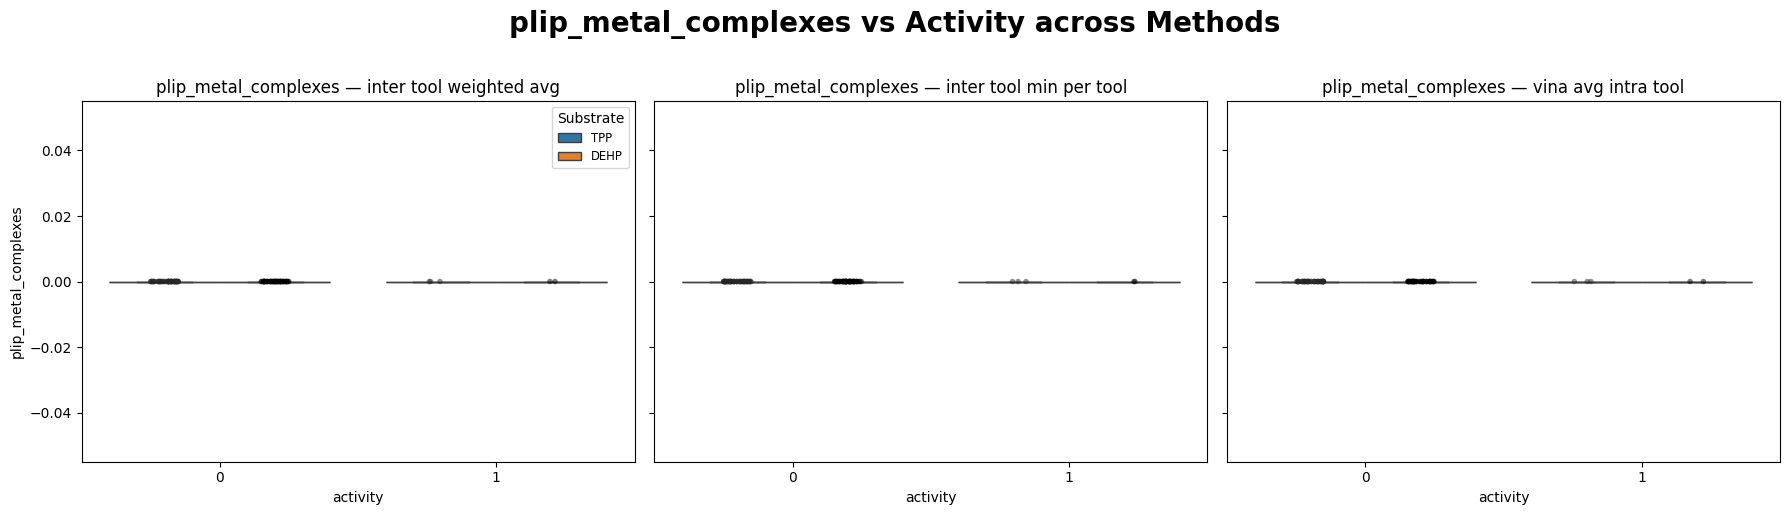

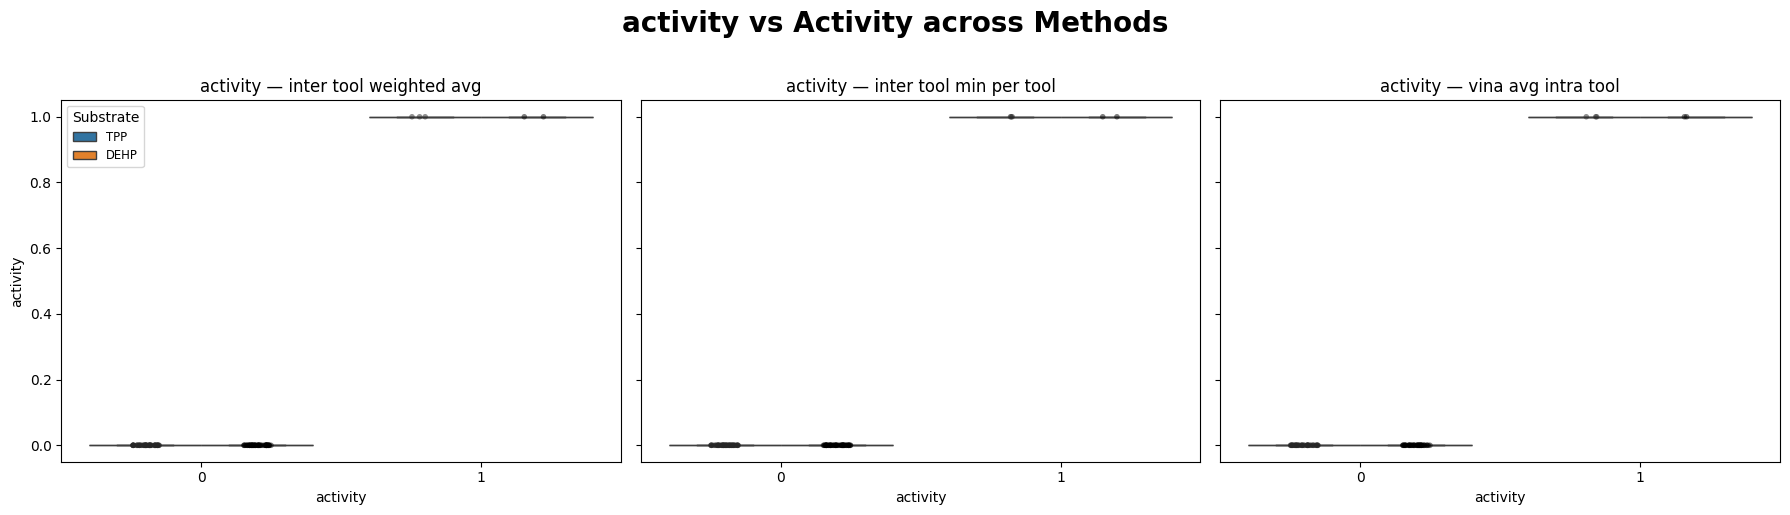

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

def feature_plots_per_substrate_all_methods(df, features, methods=['inter_tool_weighted_avg', 'inter_tool_min_per_tool', 'vina_avg_intra_tool']):
    for col in features:
        fig, axes = plt.subplots(1, len(methods), figsize=(6 * len(methods), 5), sharey=True)

        if len(methods) == 1:
            axes = [axes]  # Ensure it's iterable if only one method

        for i, method in enumerate(methods):
            ax = axes[i]
            df_method = df[df['method'] == method]

            # Boxplot
            sns.boxplot(x='activity', y=col, hue='Substrate', data=df_method, ax=ax,
                        showfliers=False, dodge=True)

            # Stripplot overlay
            sns.stripplot(x='activity', y=col, hue='Substrate', data=df_method, ax=ax,
                          palette='dark:black', dodge=True, jitter=True, size=4, alpha=0.5, legend=False)

            ax.set_title(f"{col} — {method.replace('_', ' ')}")

            if i == 0:
                ax.legend(loc='best', fontsize='small', title='Substrate')
            else:
                ax.get_legend().remove()

        fig.suptitle(f"{col} vs Activity across Methods", fontsize=20, y=1.02, fontweight='bold')
        plt.tight_layout()
        plt.show()

feature_plots_per_substrate_all_methods(df, features, methods=['inter_tool_weighted_avg', 'inter_tool_min_per_tool', 'vina_avg_intra_tool'])

### Correlation Heatmap

/tmp/ipykernel_1375284/1578090574.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_corr.values, y=activity_corr.index, palette="coolwarm", orient='h')


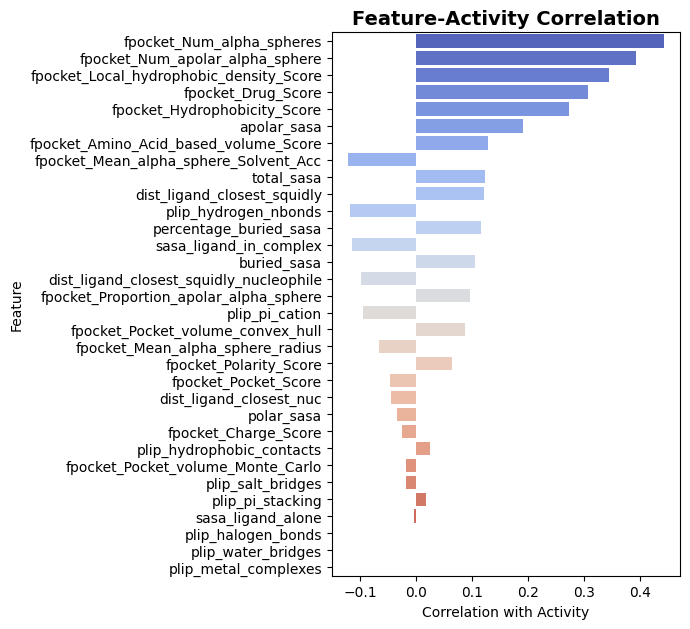

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt


# Ensure no duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Clean features list
features_clean = [f for f in features if f != 'activity']

# Compute correlation matrix
corr = df[features_clean + ['activity']].corr()

# Extract correlation with activity
activity_corr = corr.loc[features_clean, 'activity']

# Sort by absolute correlation
activity_corr = activity_corr.loc[activity_corr.abs().sort_values(ascending=False).index]

# Plot as horizontal barplot
plt.figure(figsize=(7, len(activity_corr) * 0.2))
sns.barplot(x=activity_corr.values, y=activity_corr.index, palette="coolwarm", orient='h')

plt.xlabel("Correlation with Activity")
plt.ylabel("Feature")
plt.title("Feature-Activity Correlation", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



### Dimensionality Reduction (PCA, UMAP, t-SNE)

In [69]:
features = [f for f in features if f != 'activity']

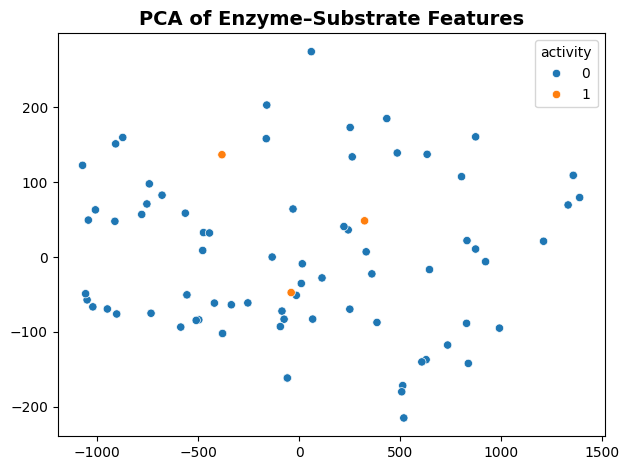

In [70]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Use DataFrame, not .values
X = df[features]
y = df['activity']

# Drop rows with NaNs (in features only)
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]  # align y with cleaned X

# PCA on cleaned data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

# Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_clean)
plt.title("PCA of Enzyme–Substrate Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Feature Importance with Models

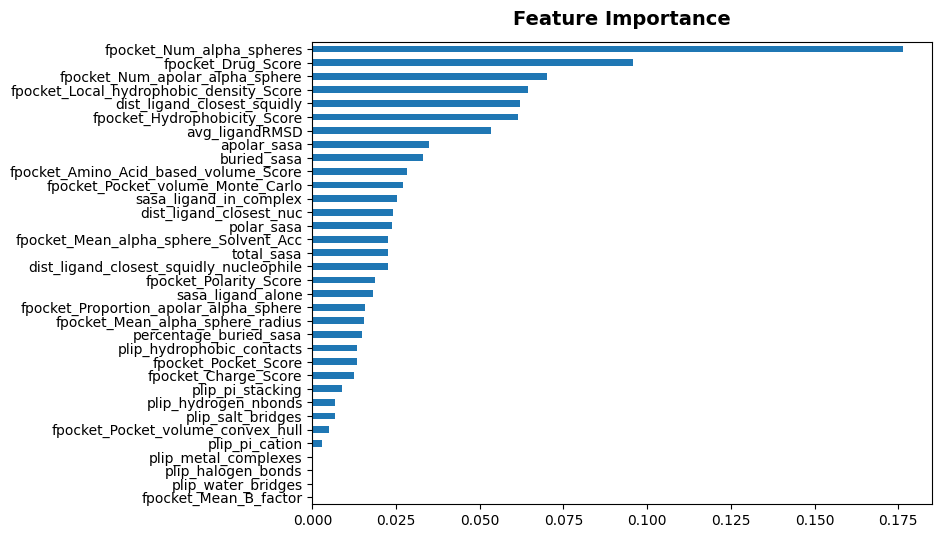

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
features = [f for f in df.select_dtypes(include=[np.number]).columns if f != 'activity']
clf.fit(df[features], df['activity'])

importances = pd.Series(clf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance", fontsize=14, y=1.02, fontweight = 'bold')
plt.show()


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
X = df[features]
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.00      0.00      0.00         0

    accuracy                           0.95        19
   macro avg       0.50      0.47      0.49        19
weighted avg       1.00      0.95      0.97        19



/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

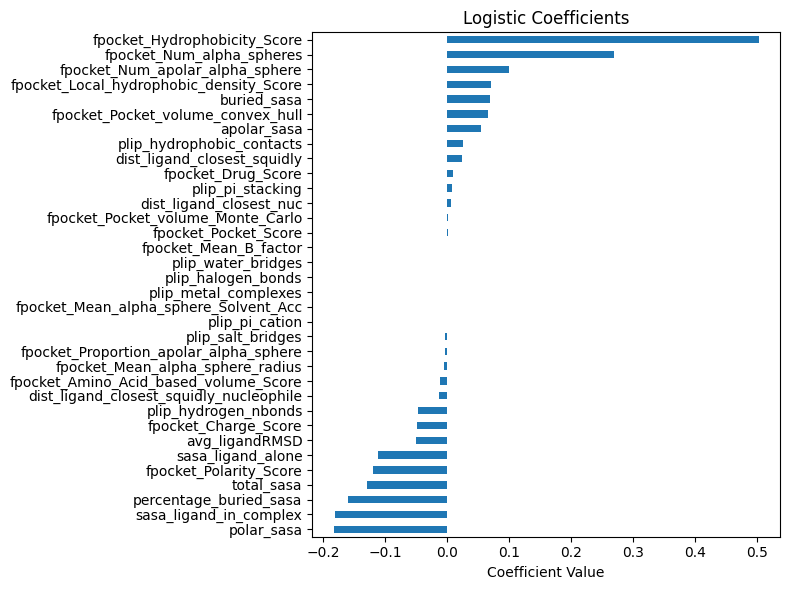

In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# STEP 1: Prepare clean training data
train = pd.concat([X_train, y_train], axis=1).dropna()
X_train_clean = train.drop(columns=y_train.name)
y_train_clean = train[y_train.name]

# STEP 2: Prepare clean test data
test = pd.concat([X_test, y_test], axis=1).dropna()
X_test_clean = test.drop(columns=y_test.name)
y_test_clean = test[y_test.name]

# STEP 3: Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_clean, y_train_clean)

# STEP 4: Predict and evaluate
y_pred = model.predict(X_test_clean)

print("Logistic Regression:")
print(classification_report(y_test_clean, y_pred))

# STEP 5: Feature importance (coefficients)
# Ensure you match the features to the correct column names
coef = pd.Series(model.coef_[0], index=X_train_clean.columns)
coef.sort_values().plot(kind='barh', figsize=(8, 6), title="Logistic Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.00      0.00      0.00         0

    accuracy                           0.95        19
   macro avg       0.50      0.47      0.49        19
weighted avg       1.00      0.95      0.97        19



/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

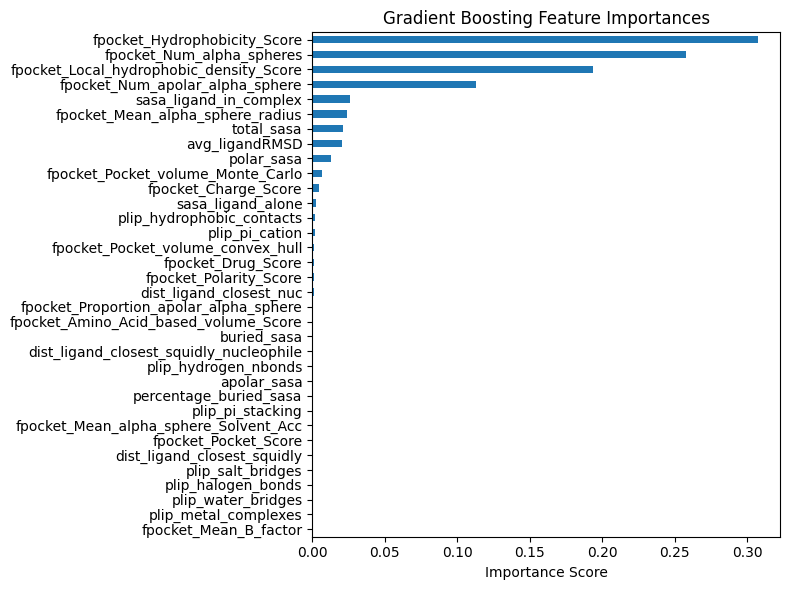

In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# STEP 1: Drop NaNs from training set
train = pd.concat([X_train, y_train], axis=1).dropna()
X_train_clean = train.drop(columns=y_train.name)
y_train_clean = train[y_train.name]

# STEP 2: Drop NaNs from test set
test = pd.concat([X_test, y_test], axis=1).dropna()
X_test_clean = test.drop(columns=y_test.name)
y_test_clean = test[y_test.name]

# STEP 3: Train Gradient Boosting model
model = GradientBoostingClassifier()
model.fit(X_train_clean, y_train_clean)

# STEP 4: Predict and evaluate
y_pred = model.predict(X_test_clean)

print("Gradient Boosting:")
print(classification_report(y_test_clean, y_pred))

# STEP 5: Feature Importance (optional)
importances = pd.Series(model.feature_importances_, index=X_train_clean.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title="Gradient Boosting Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


SVM:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.00      0.00      0.00         0

    accuracy                           0.89        19
   macro avg       0.50      0.45      0.47        19
weighted avg       1.00      0.89      0.94        19



/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

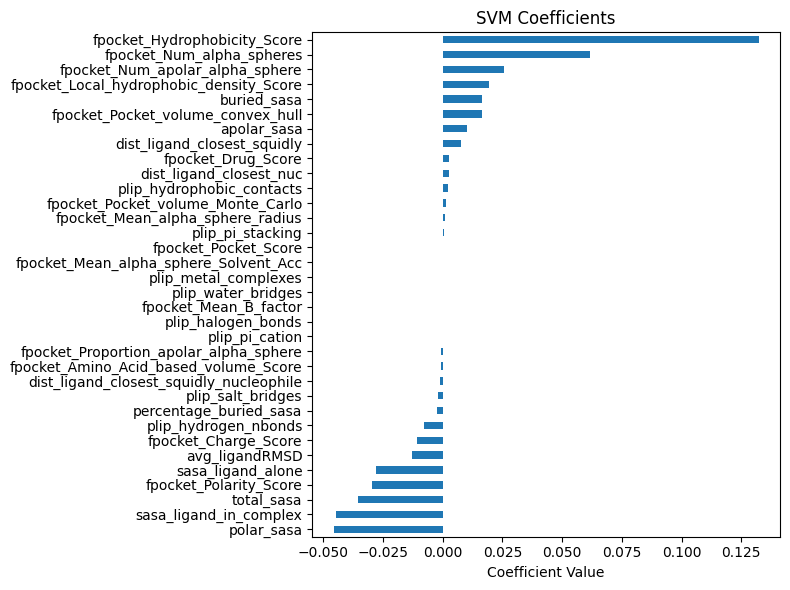

In [67]:
# SVM

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# STEP 1: Drop NaNs from train and test sets
train = pd.concat([X_train, y_train], axis=1).dropna()
X_train_clean = train.drop(columns=y_train.name)
y_train_clean = train[y_train.name]

test = pd.concat([X_test, y_test], axis=1).dropna()
X_test_clean = test.drop(columns=y_test.name)
y_test_clean = test[y_test.name]

# STEP 2: Train SVM with linear kernel
model = SVC(kernel='linear', probability=True)
model.fit(X_train_clean, y_train_clean)

# STEP 3: Predict and evaluate
y_pred = model.predict(X_test_clean)

print("SVM:")
print(classification_report(y_test_clean, y_pred))

# STEP 4: Feature importance from coefficients
coef = pd.Series(model.coef_[0], index=X_train_clean.columns)
coef.sort_values().plot(kind='barh', figsize=(8, 6), title="SVM Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()



In [66]:
# MLP

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# STEP 1: Drop NaNs from train and test sets
train = pd.concat([X_train, y_train], axis=1).dropna()
X_train_clean = train.drop(columns=y_train.name)
y_train_clean = train[y_train.name]

test = pd.concat([X_test, y_test], axis=1).dropna()
X_test_clean = test.drop(columns=y_test.name)
y_test_clean = test[y_test.name]

# STEP 2: Train a small MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,),  # one hidden layer with 50 neurons
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42)
mlp.fit(X_train_clean, y_train_clean)

# STEP 3: Predict and evaluate
y_pred = mlp.predict(X_test_clean)

print("MLP Classifier:")
print(classification_report(y_test_clean, y_pred))


MLP Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

